## Assignment
[Assignment Notes](https://docs.google.com/document/d/1vr6wHlQXA5iP5X3RzxpU3T7PHGUkQzULitxvV83Pf7Q/edit)

[Assignment Data Notes](https://docs.google.com/document/d/1DtMgMeEk8tcsI1nWqR_ika_bmDg1ADpy64as7zDqqHc/edit)

### Setup
----
##### !! NOTE !!
To run this code you need the data from [chicagobooth](https://www.chicagobooth.edu/research/kilts/datasets/dominicks), specifically the data for shampoo.

The filles needed is:

**Customoer Count File** - (ccount(stata).zip)

**Store-Level Demographics File** - (demo(stata).zip)

And from the **category file** you need to find **shampoo**, and download **UPC.csv File** and **Movement.csv File**

And all of this needs to be saved in a folder called **"data"** in the same folder you are running this script from, running the **"create_folders" function** will automatically create the folder

In [2]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import requests
import os
import chardet
import time
import csv
import gc
import re

from datetime import datetime, timedelta
from functools import reduce

import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pylab as pylab

import sympy as sp
from sympy.solvers import solve

from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from cycler import cycler

# custome plot style
params  = {
"lines.linewidth": 1.5,

"legend.fancybox": "true",

"axes.prop_cycle": cycler('color', ["#ffa822","#1ac0c6","#ff6150","#30B66A","#B06AFF","#FF21E1"]),
"axes.facecolor": "#2b2b2b",
"axes.axisbelow": "true",
"axes.grid": "true",
"axes.edgecolor": "#2b2b2b",
"axes.linewidth": 0.5,
"axes.labelpad": 0,

"patch.edgecolor": "#2b2b2b",
"patch.linewidth": 0.5,

"grid.linestyle": "--",
"grid.linewidth": 0.5,
"grid.color": "#b8aba7",

"xtick.major.size": 0,
"xtick.minor.size": 0,
"ytick.major.size": 0,
"ytick.minor.size": 0,

"font.family":"monospace",
"font.size":10.0,
"text.color": "#FFE9E3",
"axes.labelcolor": "#b8aba7",
"xtick.color": "#b8aba7",
"ytick.color": "#b8aba7",

"savefig.edgecolor": "#2b2b2b",
"savefig.facecolor": "#2b2b2b",

"figure.subplot.left": 0.08,
"figure.subplot.right": 0.95,
"figure.subplot.bottom": 0.09,
"figure.facecolor": "#2b2b2b"}

pylab.rcParams.update(params)
print("finish")

finish


In [3]:
# Collect files from folder, if file type equals file_type
def get_files(folder, file_type):
    file_paths = []
    for file in os.listdir(folder):
        if file.endswith(file_type):
            file_paths.append([os.path.join(folder, file), file_type])
    return file_paths

def get_encoder(file_path, chunksize = 10_000):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read(chunksize))
    return result['encoding']

# NOTE TO SELF, STRAGE ERROR HERE, MIGHT BE A DUPLICATE ERROR
# Load, filter in chunks and Convert to csv
def load_and_filter_file(input_file, temp_path, filter_func:list, file_type=".csv", chunksize=10_000, new_file_name = ""):
    temp_file = os.path.join(temp_path,new_file_name)
    if new_file_name == "":
        # Extract the file name from the input_file path
        input_file_name = os.path.basename(input_file)

        # Create a temp_file path by combining temp_path and input_file_name
        file_name_without_ext, file_ext = os.path.splitext(input_file_name)
        temp_file = os.path.join(temp_path, f"{file_name_without_ext}_temp.csv")
        
    # Had to fix the decoding because 'invalid continuation byte' that utf-8 can't decode. And manual attempt to fix it did not reveal byte 0xd5
    encodings = ["utf-8", "ISO-8859-1", "cp1252", "latin1"]
    success = False

    for encoding in encodings:
        try:
            if file_type.lower() == '.csv':
                reader = pd.read_csv(input_file, chunksize=chunksize, encoding=encoding)
            elif file_type.lower() == '.dta':
                reader = pd.read_stata(input_file, chunksize=chunksize)
            else:
                raise ValueError("Unsupported file type. Supported types are 'csv' and 'dta'.")

            for i, chunk in enumerate(reader):
                filtered_chunk = chunk
                for func in filter_func:
                    filtered_chunk = func(filtered_chunk)
                if i == 0:
                    filtered_chunk.to_csv(temp_file, index=False, mode='w')
                else:
                    filtered_chunk.to_csv(temp_file, index=False, mode='a', header=False)

            success = True
            print(f"Succes with the encoding '{encoding}', file {temp_file} now created")
            break

        except UnicodeDecodeError:
            print(f"Failed to read the file with encoding '{encoding}', trying the next one...")

    if not success:
        raise ValueError("None of the attempted encodings were successful in reading the file.")
        
def load_and_filter_file_full_load(input_file, temp_path, filter_func:list, file_type=".csv", new_file_name = ""):
    temp_file = os.path.join(temp_path,new_file_name)
    if new_file_name == "":
        # Extract the file name from the input_file path
        input_file_name = os.path.basename(input_file)

        # Create a temp_file path by combining temp_path and input_file_name
        file_name_without_ext, file_ext = os.path.splitext(input_file_name)
        temp_file = os.path.join(temp_path, f"{file_name_without_ext}_temp.csv")
        
    # Had to fix the decoding because 'invalid continuation byte' that utf-8 can't decode. And manual attempt to fix it did not reveal byte 0xd5
    encodings = ["utf-8", "ISO-8859-1", "cp1252", "latin1"]
    success = False

    for encoding in encodings:
        try:
            if file_type.lower() == '.csv':
                df = pd.read_csv(input_file, encoding=encoding)
            elif file_type.lower() == '.dta':
                df = pd.read_stata(input_file)
            else:
                raise ValueError("Unsupported file type. Supported types are 'csv' and 'dta'.")

            for func in filter_func:
                df = func(df)
                
            df.to_csv(temp_file, index=False)

            success = True
            print(f"Succes with the encoding '{encoding}', file {temp_file} now created")
            break

        except UnicodeDecodeError:
            print(f"Failed to read the file with encoding '{encoding}', trying the next one...")

    if not success:
        raise ValueError("None of the attempted encodings were successful in reading the file.")

            
# Merge csv files
"""
def merge_csv_files(file1, file2, output_file, merge_on=None, merge_dtype=None, chunksize=10000):
    if (merge_on is not None) and (type(merge_on) != list):  # Fix the condition here
        merge_on = [merge_on]
    
    with open(output_file, 'w', newline='', encoding='utf-8') as f_out:
        writer = None
        for chunk1 in pd.read_csv(file1, chunksize=chunksize):
            for chunk2 in pd.read_csv(file2, chunksize=chunksize):
                if merge_dtype is not None:
                    for column in merge_on:
                        chunk1[column] = chunk1[column].astype(merge_dtype)
                        chunk2[column] = chunk2[column].astype(merge_dtype)

                merged_chunk = pd.merge(chunk1, chunk2, on=merge_on) if merge_on else pd.concat([chunk1, chunk2], axis=1)

                if writer is None:
                    writer = csv.DictWriter(f_out, fieldnames=merged_chunk.columns)
                    writer.writeheader()

                for row in merged_chunk.to_dict(orient='records'):
                    writer.writerow(row)
"""

def merge_csv_files(file1, file2, output_file, merge_on= None, merge_dtype=None, chunksize =10000):
    if (merge_on is not None) and (type(merge_on) != list):  # Fix the condition here
        merge_on = [merge_on]
    
    with open(output_file, 'w', newline='', encoding='utf-8') as f_out:
        writer = None
        
        # Read the entire file2 into memory
        file2_data = pd.read_csv(file2)
        
        if merge_dtype is not None:
            for column in merge_on:
                file2_data[column] = file2_data[column].astype(merge_dtype)
        
        for chunk1 in pd.read_csv(file1, chunksize=chunksize):
            if merge_dtype is not None:
                for column in merge_on:
                    chunk1[column] = chunk1[column].astype(merge_dtype)

            merged_chunk = pd.merge(chunk1, file2_data, on=merge_on) if merge_on else pd.concat([chunk1, file2_data], axis=1)

            if writer is None:
                writer = csv.DictWriter(f_out, fieldnames=merged_chunk.columns)
                writer.writeheader()

            for row in merged_chunk.to_dict(orient='records'):
                writer.writerow(row)
                

                    
# Run time test function
def time_function(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{func.__name__} took {elapsed_time:.2f} seconds to run.")
    return result

# Folder check and creation 
def create_folders(folder_paths):
    for folder_path in folder_paths:
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder created: {folder_path}")
        else:
            print(f"Folder already exists: {folder_path}")

In [4]:
# List of filters
def empty_filter_func(chunk):
    # Empty filter for test
    return chunk

def filter_empty_to_0_and_dropna(chunk):
    # Replace empty values with 0 if the column is numeric, otherwise with NaN
    for col in chunk.columns:
        if pd.api.types.is_numeric_dtype(chunk[col]):
            chunk[col] = chunk[col].replace('', 0).fillna(0)
        else:
            chunk[col] = chunk[col].replace('', np.nan)
    
    # Drop rows with NaN values
    filtered_chunk = chunk.dropna()
    
    return filtered_chunk

def filter_remove_empty_and_nan(chunk):
    filtered_chunk = chunk.replace('', np.nan)
    # Remove rows with NaN values from the DataFrame
    filtered_chunk = filtered_chunk.dropna()
    return filtered_chunk

def filter_header_up(chunk):
    # Turn header to upper
    chunk.columns = map(str.upper, chunk.columns)
    return chunk

def filter_week(chunk):
    # The data begins from week 128 (02/20/92). To filter for the year 1993, we select week 173 to 224. Based on Dominicks Manual and Codebook - Part 8: Week’s Decode Table
    # 173 = 12/31/92 to 01/06/93
    # 124 = 12/23/93 to 12/29/93
    start_week = 173
    end_week = 224

    # Create a copy of the chunk to avoid the warning
    chunk_copy = chunk.copy()

    # Modify the 'WEEK' column in the copied chunk
    chunk_copy['WEEK'] = chunk_copy['WEEK'].astype(int)

    filtered_chunk = chunk_copy[(chunk_copy['WEEK'] >= start_week) & (chunk_copy['WEEK'] <= end_week)]
    return filtered_chunk

def filter_move_above_one(chunk):
    filtered_chunk = chunk[(chunk['MOVE'] > 0)]
    return filtered_chunk

def filter_out_bad_data(chunk):
    filtered_chunk = chunk[(chunk['OK'] > 0)]
    return filtered_chunk

def filter_keep_columns(chunk, columns_to_keep = ["STORE", "COSMETIC", "HABA","PHARMACY","WEEK"]):
    # Keep only the specified columns in the DataFrame
    filtered_chunk = chunk[columns_to_keep]
    return filtered_chunk

def remove_column(chunk):
    column_names = ["GINI","LIFT5","RATIO5"]
    for column_name in column_names:
        if column_name in chunk.columns:
            chunk = chunk.drop(column_name, axis=1)
    return chunk

def combine_same_week_and_store(chunk):
    # Combine rows with the same value in the "WEEK" column
    combined_chunk = chunk.groupby(["WEEK","STORE"]).sum().reset_index()
    return combined_chunk

def filter_remove_symb_in_description(chunk):
    # Combine rows with the same value in the "WEEK" column
    chunk["DESCRIP"] = chunk["DESCRIP"].apply(lambda x: re.sub(r'&', ' ANNNND ', x))
    chunk["DESCRIP"] = chunk["DESCRIP"].apply(lambda x: re.sub(r'[^\w]', '', x))
    chunk["DESCRIP"] = chunk["DESCRIP"].apply(lambda x: re.sub(r' ANNNND ', '&', x))
    chunk["DESCRIP"] = chunk["DESCRIP"].apply(lambda x: re.sub(r' +', ' ', x))
    return chunk

def filter_clean_text_data(chunk, column = "DESCRIP"):
    # Convert to uppercase, remove symbols, and remove extra spaces
    chunk[column] = (chunk[column].str.upper()
                                  .str.replace(r"\W+", " ", regex=True)
                                  .str.replace(r"\s{2,}", " ", regex=True)
                                  .str.strip()
                                  .str.replace(r"(?<!\S)\S(?!\S)", "", regex=True))
    return chunk


### Filter and Clean Data
---

In [5]:
folder_path = "data/" # folder with data
folder_path_temp = "data_temp/" # folder with temp data
folder_path_clean = "data_clean/" # folder with clean
chunk_size = 10_000 # chunks of data loaderd in memory

create_folders([folder_path, folder_path_temp,folder_path_clean])

file_paths = get_files(folder_path,".csv")
file_paths.extend(get_files(folder_path,".dta"))

print(file_paths)

Folder already exists: data/
Folder created: data_temp/
Folder created: data_clean/
[['data/upcsha.csv', '.csv'], ['data/wsha.csv', '.csv'], ['data/ccount.dta', '.dta'], ['data/demo.dta', '.dta']]


#### upc data

In [6]:
filter_func_list = [filter_header_up,filter_remove_empty_and_nan,filter_clean_text_data]
time_function(load_and_filter_file, file_paths[0][0], folder_path_temp, filter_func_list, file_type=file_paths[0][1], chunksize = chunk_size)

# Can add and clean description and add brands here.

Failed to read the file with encoding 'utf-8', trying the next one...
Succes with the encoding 'ISO-8859-1', file data_temp/upcsha_temp.csv now created
load_and_filter_file took 0.07 seconds to run.


#### walk data

In [7]:
filter_func_list = [filter_header_up,filter_remove_empty_and_nan,filter_week,filter_move_above_one,filter_out_bad_data]
time_function(load_and_filter_file, file_paths[1][0], folder_path_temp, filter_func_list, file_type=file_paths[1][1], chunksize = chunk_size)

Succes with the encoding 'utf-8', file data_temp/wsha_temp.csv now created
load_and_filter_file took 35.93 seconds to run.


#### custumer count

In [8]:
filter_func_list = [filter_header_up,filter_remove_empty_and_nan,filter_week,filter_keep_columns, combine_same_week_and_store]
time_function(load_and_filter_file, file_paths[2][0], folder_path_temp, filter_func_list, file_type=file_paths[2][1], chunksize = chunk_size)

Succes with the encoding 'utf-8', file data_temp/ccount_temp.csv now created
load_and_filter_file took 1.66 seconds to run.


#### demo

In [9]:
filter_func_list = [filter_header_up, remove_column,filter_empty_to_0_and_dropna]
time_function(load_and_filter_file, file_paths[3][0], folder_path_temp, filter_func_list, file_type=file_paths[3][1], chunksize = chunk_size)

Succes with the encoding 'utf-8', file data_temp/demo_temp.csv now created
load_and_filter_file took 0.35 seconds to run.


### Merge Data
----

In [10]:
merge_file_main = "data_temp/wsha_temp.csv"
merge_file_sec = "data_temp/upcsha_temp.csv"
merge_file_out = "data_temp/wsha_upcsha.csv"
time_function(merge_csv_files,merge_file_main, merge_file_sec, merge_file_out, merge_on="UPC", merge_dtype=np.int64, chunksize=chunk_size)

merge_csv_files took 3.69 seconds to run.


In [11]:
merge_file_main = "data_temp/wsha_upcsha.csv"
merge_file_sec = "data_temp/ccount_temp.csv"
merge_file_out = "data_temp/wsha_upcsha_ccount.csv"
time_function(merge_csv_files,merge_file_main, merge_file_sec, merge_file_out, merge_on=["STORE","WEEK"], merge_dtype=np.int64, chunksize=chunk_size)

merge_csv_files took 4.29 seconds to run.


In [12]:
merge_file_main = "data_temp/wsha_upcsha_ccount.csv"
merge_file_sec = "data_temp/demo_temp.csv"
merge_file_out = "data_temp/wsha_upcsha_ccount_demo.csv"
time_function(merge_csv_files,merge_file_main, merge_file_sec, merge_file_out, merge_on="STORE", merge_dtype=np.int64, chunksize=chunk_size)

merge_csv_files took 104.57 seconds to run.


### Clean Merge Data and Select Relevant Column
----

In [13]:
selected_columns = ["STORE", "CITY", "WEEK","MOVE","PRICE","QTY","PROFIT","DESCRIP","CASE","COSMETIC","HABA","PHARMACY","INCOME","HSIZEAVG","HSIZE1","HSIZE2",
                    "HSIZE34","HHLARGE","SINGLE","RETIRED","UNEMP","WORKWOM","WRKCH5","WRKCH17","NWRKCH5","NWRKCH17","WRKCH","NWRKCH","WRKWNCH"]

def filter_select_columns(chunk, columns_to_keep = selected_columns):
    # Keep only the specified columns in the DataFrame
    filtered_chunk = chunk[columns_to_keep]
    return filtered_chunk

def filter_upc(chunk):
    filtered_chunk = chunk[(chunk["UPC"].isin(upc_list[-1]))]
    return filtered_chunk

def filter_create_sales_column(chunk):
    # Create a temporary DataFrame to avoid unkown SettingWithCopyWarning
    # NOTE I still get the error, tho the code works. 
    # Error is most likly panda not knowing wheter I want to create a copy or work with the main chunk. 
    tmp = chunk['PRICE'] * chunk["MOVE"] / chunk['QTY']
    
    # Assign the temporary DataFrame to the new column 'SALES'
    chunk = chunk.assign(SALES=tmp)

    return chunk


filter_func_list = [filter_select_columns,filter_create_sales_column]
file_main = "data_temp/wsha_upcsha_ccount_demo.csv"
file_out = "shampoo_sale_data.csv"
time_function(load_and_filter_file, file_main, folder_path_clean, filter_func_list, chunksize = chunk_size, new_file_name = file_out)

Succes with the encoding 'utf-8', file data_clean/shampoo_sale_data.csv now created
load_and_filter_file took 14.46 seconds to run.


In [14]:
"""
def group_data(input_file, column, chunksize=10_000):
    groups = {}
    # Read the file in chunks
    for chunk in pd.read_csv(input_file, chunksize=chunksize):
        # Iterate over the cleaned data
        for index, row in chunk.iterrows():
            # Check if the description is missing
            if pd.isna(row[column]):
                continue
                
            # Split the description into words
            words = row[column].split()

            # Define the key as the first word or a group of similar words
            key = words[0]

            # Add the description to the corresponding group
            if key not in groups:
                groups[key] = []
            groups[key].append(row[column])

    return groups
"""
def group_data(input_file, column):
    groups = {}
    df = pd.read_csv(input_file)

    # Iterate over the cleaned data
    for index, row in df.iterrows():
        # Check if the description is missing
        if pd.isna(row[column]):
            continue
            
        # Split the description into words
        words = row[column].split()

        # Define the key as the first word or a group of similar words
        key = words[0]

        # Add the description to the corresponding group
        if key not in groups:
            groups[key] = []
        groups[key].append(row[column])

    return groups
keyword_brand_grouping = time_function(group_data,"data_clean/shampoo_sale_data.csv", "DESCRIP")
#display(keyword_brand_grouping)

group_data took 7.54 seconds to run.


In [15]:
"""
def group_by_keyword(input_file, output_file, column, keyword_dict, group_columns=["WEEK", "STORE"], chunksize=10_000):
    # Define a function to map each description to its keyword
    def map_to_keyword(description):
        if isinstance(description, str):
            words = description.split()
            for word in words:
                if word in keyword_dict:
                    return word
        return description

    # Define a function to process each chunk of the DataFrame
    def process_chunk(chunk):
        chunk["BRAND"] = chunk[column].apply(map_to_keyword)
        grouped = chunk.groupby(group_columns + ["BRAND"]).sum(numeric_only=True).reset_index()
        return grouped

    # Process the DataFrame in chunks and concatenate the results
    grouped_chunks = [process_chunk(chunk) for chunk in pd.read_csv(input_file, chunksize=chunksize)]
    result = pd.concat(grouped_chunks)

    # Save the result to a new CSV file
    result.to_csv(output_file, index=False)

    print(f"The file has been processed and saved as {output_file}")
"""
""""
def group_by_keyword(input_file, output_file, column, keyword_dict, group_columns=["WEEK", "STORE"], chunksize=10_000):
    # Define a function to map each description to its keyword
    def map_to_keyword(description):
        if isinstance(description, str):
            words = description.split()
            for word in words:
                if word in keyword_dict:
                    return word
        return description

    # Define a function to process each chunk of the DataFrame
    def process_chunk(chunk):
        chunk["BRAND"] = chunk[column].apply(map_to_keyword)
        grouped = chunk.groupby(group_columns + ["BRAND"]).sum(numeric_only=True).reset_index()
        return grouped

    # Process the DataFrame in chunks and concatenate the results
    grouped_chunks = [process_chunk(chunk) for chunk in pd.read_csv(input_file, chunksize=chunksize)]
    result = pd.concat(grouped_chunks)

    # Save the result to a new CSV file
    result.to_csv(output_file, index=False)

    print(f"The file has been processed and saved as {output_file}")
"""

def group_by_keyword(input_file, output_file, column, keyword_dict, group_columns=["WEEK", "STORE"]):
    # Define a function to map each description to its keyword
    def map_to_keyword(description):
        if isinstance(description, str):
            words = description.split()
            for word in words:
                if word in keyword_dict:
                    return word
        return description

    # Load the DataFrame
    df = pd.read_csv(input_file)

    # Map keywords to a new "BRAND" column
    df["BRAND"] = df[column].apply(map_to_keyword)

    # Group by the defined columns
    grouped = df.groupby(group_columns + ["BRAND"]).sum(numeric_only=True).reset_index()

    # Save the result to a new CSV file
    grouped.to_csv(output_file, index=False)

    print(f"The file has been processed and saved as {output_file}")

input_file = "data_clean/shampoo_sale_data.csv"
output_file = "data_clean/shampoo_sale_data_brand.csv"
column = "DESCRIP"
group_columns = ["STORE", "WEEK"]

time_function(group_by_keyword,input_file, output_file, column, keyword_brand_grouping, group_columns)

The file has been processed and saved as data_clean/shampoo_sale_data_brand.csv
group_by_keyword took 1.47 seconds to run.


### Selected Data
----

**STORE:** This is the unique identifier for each store location.

**WEEK:** This denotes the week number when the sales occurred.

**MONTH:** This is the month when the sakes occured.

**BRAND:** This is the descriptive name for the brand of the product.

**MOVE:** This is the number of units of the product that were sold.

**PRICE:** This is the retail price of the product.

**QTY:** This is the number of items bundled together.

**CASE:** This is the number of items in a case.

**COSMETIC, HABA, PHARMACY:** These variables are to be related to the different categories of products, and Sales in Dollars.

**INCOME:** This is the gross income, cents on the dollar for each item sold.

**HSIZEAVG, HSIZE1, HSIZE2, HSIZE34, HHLARGE:** These variables seem to represent household sizes.

**SINGLE, RETIRED, UNEMP, WORKWOM, WRKCH5, WRKCH17, NWRKCH5, NWRKCH17, WRKCH, NWRKCH, WRKWNCH:** These variables represent different demographics related to employment and family status.

**SALES (PRICE*MOVE/QTY):** This is a calculated field representing total sales.

### Might be old code, cant remember
----

In [16]:
"""
def top_n_values_with_names(input_file, column_number, column_name, n=5):
    df = pd.read_csv(input_file)

    # Sort the DataFrame based on the values in the specified column_number
    sorted_df = df.sort_values(by=column_number, ascending=False)

    # Get the top N rows from the sorted DataFrame
    top_n_rows = sorted_df.head(n)

    # Create a list with the top N values and their corresponding names from column_name
    result = top_n_rows[[column_number, column_name]].values.tolist()

    return result

input_file = 'data_clean/shampoo_sale_data_brand.csv'
column_number = 'MOVE'
column_name = 'BRAND'

n = 5
top_n_values = top_n_values_with_names(input_file, column_number,column_name, n)
display(top_n_values)

upc_list = [[row[i] for row in top_n_values] for i in range(2)] #top_n_values reordered to [[move...],[descrip...],[upc...]]
display(upc_list)
"""

"\ndef top_n_values_with_names(input_file, column_number, column_name, n=5):\n    df = pd.read_csv(input_file)\n\n    # Sort the DataFrame based on the values in the specified column_number\n    sorted_df = df.sort_values(by=column_number, ascending=False)\n\n    # Get the top N rows from the sorted DataFrame\n    top_n_rows = sorted_df.head(n)\n\n    # Create a list with the top N values and their corresponding names from column_name\n    result = top_n_rows[[column_number, column_name]].values.tolist()\n\n    return result\n\ninput_file = 'data_clean/shampoo_sale_data_brand.csv'\ncolumn_number = 'MOVE'\ncolumn_name = 'BRAND'\n\nn = 5\ntop_n_values = top_n_values_with_names(input_file, column_number,column_name, n)\ndisplay(top_n_values)\n\nupc_list = [[row[i] for row in top_n_values] for i in range(2)] #top_n_values reordered to [[move...],[descrip...],[upc...]]\ndisplay(upc_list)\n"

In [17]:
"""
def process_and_group_rows(input_file, output_file, column, merge_on_columns):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_file)

    # Remove any symbols or spaces at the first position in the specified column
    df[column] = df[column].apply(lambda x: re.sub(r'^[^\w\d]*', '', x))

    # Extract keywords and create a dictionary of unique keywords and their corresponding values
    keywords = set(df[column].apply(lambda x: x.split('_')[0].split()[0]))
    keyword_groups = {}
    for keyword in keywords:
        values = []
        for value in df[column].unique():
            if value.startswith(keyword):
                values.append(value)
                continue
            split_value = value.split()
            for idx, word in enumerate(split_value):
                if keyword == ' '.join(split_value[:idx + 1]):
                    values.append(value)
                    break
        keyword_groups[keyword] = values

    # Group rows based on the keyword and merge them under a new value named after the keyword
    grouped_rows = []
    for keyword, values in keyword_groups.items():
        keyword_rows = df[df[column].isin(values)].copy()  # Create a copy of the filtered DataFrame
        keyword_rows.loc[:, column] = keyword  # Use .loc[] to set the value
        group_columns = merge_on_columns + [column]
        merged_rows = keyword_rows.groupby(group_columns, as_index=False).sum(numeric_only=True)
        grouped_rows.append(merged_rows)

    # Concatenate grouped rows and save the result to a new CSV file
    result = pd.concat(grouped_rows)
    result.to_csv(output_file, index=False)

    print(f"The file has been processed and saved as {output_file}")


input_file = "data_clean/shampoo_sale_data.csv"
output_file = "data_clean/shampoo_sale_data_test.csv"
column = "DESCRIP"
merge_on_columns = ["STORE", "WEEK"]

time_function(process_and_group_rows,input_file, output_file, column, merge_on_columns)
"""
"""
def get_common_start(strings):
    #Find the common starting substring in a list of strings.
    if not strings:
        return ''
    
    # Sort the strings and compare the first and last one
    strings = sorted(strings)
    first = strings[0]
    last = strings[-1]
    common_start = []
    
    for char1, char2 in zip(first, last):
        if char1 == char2:
            common_start.append(char1)
        else:
            break  # Stop at the first mismatch
    
    return ''.join(common_start)

def process_and_group_rows(input_file, output_file):
    df = pd.read_csv(input_file)

    # Clean the 'DESCRIP' column
    df['DESCRIP'] = df['DESCRIP'].str.upper().str.replace(r'\W+', ' ', regex=True)

    # Extract first word as the main category
    df['group'] = df['DESCRIP'].str.split().str[0]

    # Group the DataFrame by 'group', 'STORE', and 'WEEK' and calculate the sum
    grouped_df = df.groupby(['group', 'STORE', 'WEEK'], as_index=False).sum()

    # Write the result to a new CSV file
    grouped_df.to_csv(output_file, index=False)

    print(f"The file has been processed and saved as {output_file}")


input_file = "data_clean/shampoo_sale_data.csv"
output_file = "data_clean/shampoo_sale_data_test.csv"
column = "DESCRIP"
merge_on_columns = ["STORE", "WEEK"]

time_function(process_and_group_rows,input_file, output_file)
"""

'\ndef get_common_start(strings):\n    #Find the common starting substring in a list of strings.\n    if not strings:\n        return \'\'\n    \n    # Sort the strings and compare the first and last one\n    strings = sorted(strings)\n    first = strings[0]\n    last = strings[-1]\n    common_start = []\n    \n    for char1, char2 in zip(first, last):\n        if char1 == char2:\n            common_start.append(char1)\n        else:\n            break  # Stop at the first mismatch\n    \n    return \'\'.join(common_start)\n\ndef process_and_group_rows(input_file, output_file):\n    df = pd.read_csv(input_file)\n\n    # Clean the \'DESCRIP\' column\n    df[\'DESCRIP\'] = df[\'DESCRIP\'].str.upper().str.replace(r\'\\W+\', \' \', regex=True)\n\n    # Extract first word as the main category\n    df[\'group\'] = df[\'DESCRIP\'].str.split().str[0]\n\n    # Group the DataFrame by \'group\', \'STORE\', and \'WEEK\' and calculate the sum\n    grouped_df = df.groupby([\'group\', \'STORE\', \'WE

### Weekly Raport
----

#### Filter and create a data set for a weekly report

In [18]:
def most_frequent_value(csv_file, store_column, week_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Calculate the frequency of each value in the specified store column
    store_value_counts = df[store_column].value_counts()
    most_frequent_store = store_value_counts.idxmax()
    store_frequency = store_value_counts[most_frequent_store]

    # Filter the DataFrame to keep only the most frequent store
    store_df = df[df[store_column] == most_frequent_store]

    # Calculate the frequency of each value in the specified week column
    week_value_counts = store_df[week_column].value_counts()
    most_frequent_week = week_value_counts.idxmax()
    week_frequency = week_value_counts[most_frequent_week]
    
    print(f"The {store_column} with the highest frequency is {most_frequent_store}, with a frequency of {store_frequency}")
    print(f"The {week_column} with the highest frequency within the store {most_frequent_store} is {most_frequent_week}, with a frequency of {week_frequency}")
    return most_frequent_store, most_frequent_week

def median_week_most_frequent_store(csv_file, store_column, week_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Calculate the median of the week column
    median_week = df[week_column].median()

    # Filter the DataFrame to keep only the rows with the week equal to the median week
    week_df = df[df[week_column] == median_week]

    # Calculate the frequency of each value in the specified store column within the median week
    store_value_counts = week_df[store_column].value_counts()
    most_frequent_store = store_value_counts.idxmax()
    store_frequency = store_value_counts[most_frequent_store]

    print(f"The median {week_column} is {median_week}")
    print(f"The {store_column} with the highest frequency within the week {median_week} is {most_frequent_store}, with a frequency of {store_frequency}")
    
    return median_week, most_frequent_store

file_main = "data_clean/shampoo_sale_data_brand.csv"
store_column = "STORE"
week_column = "WEEK"
#most_frequent_store, most_frequent_week = most_frequent_value(file_main, store_column, week_column)
most_frequent_week, most_frequent_store = median_week_most_frequent_store(file_main, store_column, week_column)

The median WEEK is 199.0
The STORE with the highest frequency within the week 199.0 is 134, with a frequency of 8


In [19]:
def filter_select_week(df):
    chunk_copy = df.copy()

    # Modify the 'WEEK' column in the copied chunk
    chunk_copy['WEEK'] = chunk_copy['WEEK'].astype(int)

    filtered_chunk = chunk_copy[(chunk_copy['WEEK'] >= most_frequent_week-1) & (chunk_copy['WEEK'] <= most_frequent_week)]
    return filtered_chunk

def filter_select_store(df):
    chunk_copy = df.copy()

    # Modify the 'WEEK' column in the copied chunk
    chunk_copy['STORE'] = chunk_copy['STORE'].astype(int)

    filtered_chunk = chunk_copy[(chunk_copy['STORE'] == most_frequent_store)]
    return filtered_chunk

def filter_top_brands(df, top_n=5):
    # Group the data by 'BRAND' and sum 'MOVE' values for each brand
    total_moves = df.groupby('BRAND')['MOVE'].sum()
    
    # Get the top 'n' brands by total 'MOVE'
    top_brands = total_moves.nlargest(top_n).index
    
    # Filter the chunk to keep only the rows with a 'BRAND' in 'top_brands'
    df_top_brand = df[df['BRAND'].isin(top_brands)]
    
    return df_top_brand

def filter_top_brands_by_week(df):
    # Group the DataFrame by 'WEEK' and 'BRAND', then calculate the median 'MOVE' for each group
    grouped = df.groupby(['WEEK', 'BRAND'])['MOVE'].median().reset_index()

    # Sort the DataFrame by 'MOVE' in descending order within each 'WEEK'
    sorted_grouped = grouped.sort_values(['WEEK', 'MOVE'], ascending=[True, False])

    # Group by 'WEEK' again and take the top 5 'BRAND' for each 'WEEK'
    top_brands_by_week = sorted_grouped.groupby('WEEK').head(5)

    # Merge the original DataFrame with the top brands DataFrame to get only the rows for the top brands
    filtered_df = df.merge(top_brands_by_week[['WEEK', 'BRAND']], on=['WEEK', 'BRAND'])

    return filtered_df

def filter_and_adjust_brands(df, specific_week=most_frequent_week):
    # Calculate the median 'MOVE' for each brand in the specific week
    specific_week_df = df[df['WEEK'] == specific_week]
    median_moves = specific_week_df.groupby('BRAND')['MOVE'].median().nlargest(5)

    # Get the top 5 brands for the specific week
    top_brands = median_moves.index.tolist()

    # Create a copy of df to avoid changing the original DataFrame
    df_copy = df.copy()
    
    # Replace all brands not in top_brands with "*"
    df_copy['BRAND'] = df_copy['BRAND'].apply(lambda brand: brand if brand in top_brands else f"*_{brand}")

    # List of unique weeks and stores
    unique_weeks = df['WEEK'].unique()
    unique_stores = df['STORE'].unique()

    # Iterate over all combinations of weeks, stores, and top brands, and add rows with all other columns set to 0 where needed
    for week in unique_weeks:
        for store in unique_stores:
            for brand in top_brands:
                if not ((df_copy['WEEK'] == week) & (df_copy['STORE'] == store) & (df_copy['BRAND'] == brand)).any():
                    new_row = {'WEEK': week, 'STORE': store, 'BRAND': brand, 'MOVE': 0, 'SALES': 0, 'QTY': 0, 'PRICE': 0}
                    df_copy = df_copy.append(new_row, ignore_index=True)
    
    return df_copy


filter_func_list = [filter_select_store,filter_select_week,filter_and_adjust_brands]
file_main = "data_clean/shampoo_sale_data_brand.csv"
file_out = "week_shampoo_sale_data.csv"
time_function(load_and_filter_file_full_load, file_main, folder_path_clean, filter_func_list, new_file_name = file_out)

Succes with the encoding 'utf-8', file data_clean/week_shampoo_sale_data.csv now created
load_and_filter_file_full_load took 0.18 seconds to run.


C:\Users\gameb\AppData\Local\Temp\ipykernel_25144\518853319.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_copy = df_copy.append(new_row, ignore_index=True)
C:\Users\gameb\AppData\Local\Temp\ipykernel_25144\518853319.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_copy = df_copy.append(new_row, ignore_index=True)


In [20]:
# Load the data
input_file = "data_clean/week_shampoo_sale_data.csv"
df_week = pd.read_csv(input_file)

display(df_week)

,STORE,WEEK,BRAND,MOVE,PRICE,QTY,PROFIT,CASE,COSMETIC,HABA,...,UNEMP,WORKWOM,WRKCH5,WRKCH17,NWRKCH5,NWRKCH17,WRKCH,NWRKCH,WRKWNCH,SALES
0,134,198,*_AQUA,12,7.40,6,131.46,72.0,14874.6594,99630.06,...,1.167922,2.328698,0.662284,0.863668,0.795156,0.362284,1.525952,1.157439,1.210204,15.22
1,134,198,*_IVORY,6,8.94,6,124.80,72.0,14874.6594,99630.06,...,1.167922,2.328698,0.662284,0.863668,0.795156,0.362284,1.525952,1.157439,1.210204,8.94
2,134,198,STUDIO,17,30.32,8,283.07,48.0,19832.8792,132840.08,...,1.557230,3.104930,0.883045,1.151557,1.060208,0.483045,2.034602,1.543253,1.613606,64.43
3,134,198,*_STYLE,16,6.20,5,93.12,30.0,12395.5495,83025.05,...,0.973269,1.940581,0.551903,0.719723,0.662630,0.301903,1.271626,0.964533,1.008503,19.54
4,134,198,*_SYYLE,3,1.19,1,17.22,6.0,2479.1099,16605.01,...,0.194654,0.388116,0.110381,0.143945,0.132526,0.060381,0.254325,0.192907,0.201701,3.57
5,134,198,*_VIBRANCE,27,36.18,14,205.04,84.0,34707.5386,232470.14,...,2.725153,5.433628,1.545329,2.015225,1.855363,0.845329,3.560554,2.700692,2.823810,74.69
6,134,198,VO,9,1.09,1,14.77,12.0,2479.1099,16605.01,...,0.194654,0.388116,0.110381,0.143945,0.132526,0.060381,0.254325,0.192907,0.201701,9.81
7,134,198,VO5,55,7.63,7,103.46,84.0,17353.7693,116235.07,...,1.362576,2.716814,0.772664,1.007612,0.927682,0.422664,1.780277,1.350346,1.411905,59.95
8,134,199,BOLD,11,9.54,6,113.16,36.0,8611.9800,89820.72,...,1.167922,2.328698,0.662284,0.863668,0.795156,0.362284,1.525952,1.157439,1.210204,17.49
9,134,199,*_HOT,1,3.79,1,33.50,6.0,1435.3300,14970.12,...,0.194654,0.388116,0.110381,0.143945,0.132526,0.060381,0.254325,0.192907,0.201701,3.79


*_ means that it is a brand that is not a part of the 5 brands.

#### Graph and data on weekly sales, income, and inventory for one store.

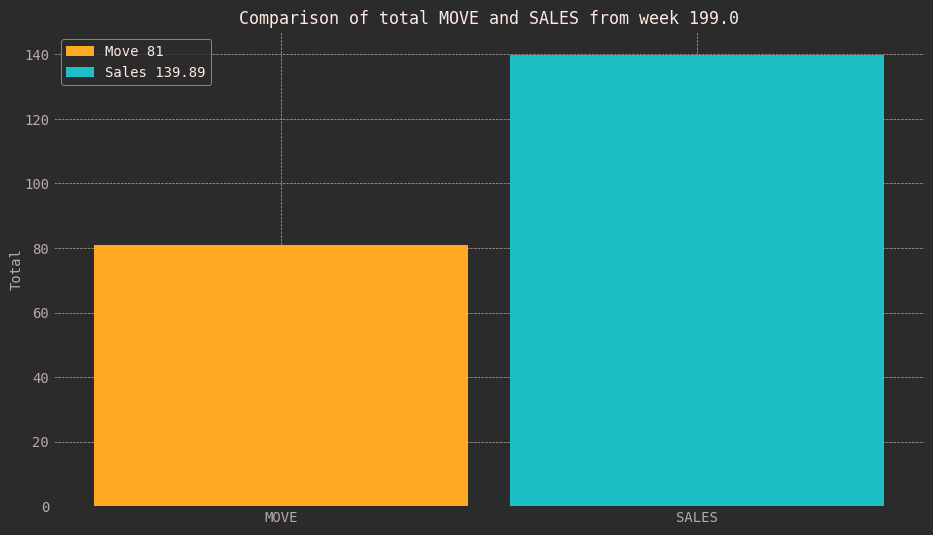

In [21]:
def brand_check(df):
    # Filter out all brands that are not from the 5 selected
    df_checked = df[~df['BRAND'].str.startswith('*')]
    return df_checked

def compare_weeks(df, week1):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    # Filter the data for the given weeks
    week1_data = df[df['WEEK'] == week1]

    # Calculate the total 'MOVE' and 'SALES' for each week
    total_move_week1 = week1_data['MOVE'].sum()
    total_sales_week1 = week1_data['SALES'].sum()

    # Create a bar plot
    labels = ['MOVE', 'SALES']
    week1_total_move = [total_move_week1, 0]
    week1_total_sale = [0, total_sales_week1]
    x = range(len(labels))  # the label locations

    plt.figure(figsize=(10, 6))
    plt.bar(x, week1_total_move, width=.9, label=f"Move {total_move_week1}", align='center')
    plt.bar(x, week1_total_sale, width=.9, label=f"Sales {total_sales_week1}", align='center')
    plt.xticks(x, labels)
    plt.ylabel('Total')
    plt.title(f'Comparison of total MOVE and SALES from week {week1}')
    plt.legend()
    plt.show()
    
compare_weeks(df_week, most_frequent_week)

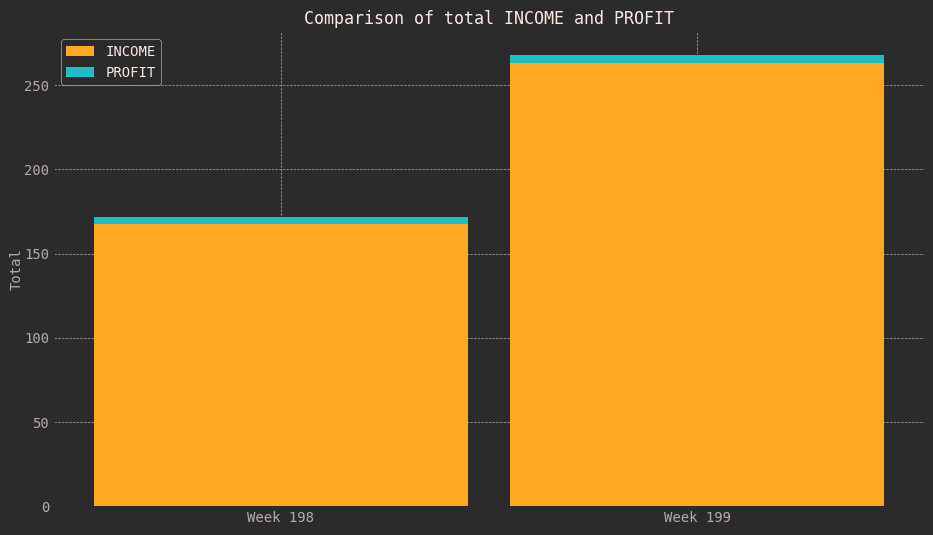

In [22]:
"""
def compare_weeks(df, week1, week2):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    # Filter the data for the given weeks
    week1_data = df[df['WEEK'] == week1]
    week2_data = df[df['WEEK'] == week2]

    # Calculate the total 'MOVE' and 'SALES' for each week
    total_profit_week1 = week1_data['PROFIT'].sum()
    total_income_week1 = week1_data['INCOME'].sum()

    total_profit_week2 = week2_data['PROFIT'].sum()
    total_income_week2 = week2_data['INCOME'].sum()

    # Create a bar plot
    labels = ['PROFIT', 'INCOME']
    week1_totals = [total_profit_week1, total_income_week1]
    week2_totals = [total_profit_week2, total_income_week2]

    x = range(len(labels))  # the label locations

    plt.figure(figsize=(10, 6))
    plt.bar(x, week1_totals, width=0.4, label=f'Week {week1}', align='center')
    plt.bar(x, week2_totals, width=0.4, label=f'Week {week2}', align='edge')

    plt.xticks(x, labels)
    plt.ylabel('Total')
    plt.title(f'Comparison of total INCOME and PROFIT between week {week1} and {week2}')
    plt.legend()
    plt.show()
"""
def compare_weeks(df, week1, week2):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    # Filter the data for the given weeks
    week1_data = df[df['WEEK'] == week1]
    week2_data = df[df['WEEK'] == week2]

    # Calculate the total 'PROFIT' and 'INCOME' for each week
    total_income_week1 = week1_data['INCOME'].sum()
    total_profit_week1 = week1_data['PROFIT'].sum()/100


    total_income_week2 = week2_data['INCOME'].sum()
    total_profit_week2 = week2_data['PROFIT'].sum()/100


    # Create a bar plot
    labels = [f'Week {int(week1)}', f'Week {int(week2)}']
    profit_totals = [total_profit_week1, total_profit_week2]
    cost_totals = [total_income_week1 - total_profit_week1, total_income_week2 - total_profit_week2]

    x = np.arange(len(labels))  # the label locations

    plt.figure(figsize=(10, 6))
    plt.bar(x, cost_totals, width=.9, label='INCOME')
    plt.bar(x, profit_totals, width=.9, label='PROFIT', bottom=cost_totals)

    plt.xticks(x, labels)
    plt.ylabel('Total')
    plt.title('Comparison of total INCOME and PROFIT')
    plt.legend()
    plt.show()

compare_weeks(df_week, most_frequent_week-1, most_frequent_week)

NOTE this does not seem right.
Change this to profit * Sales

#### Week-over-week comparison of sales and income.

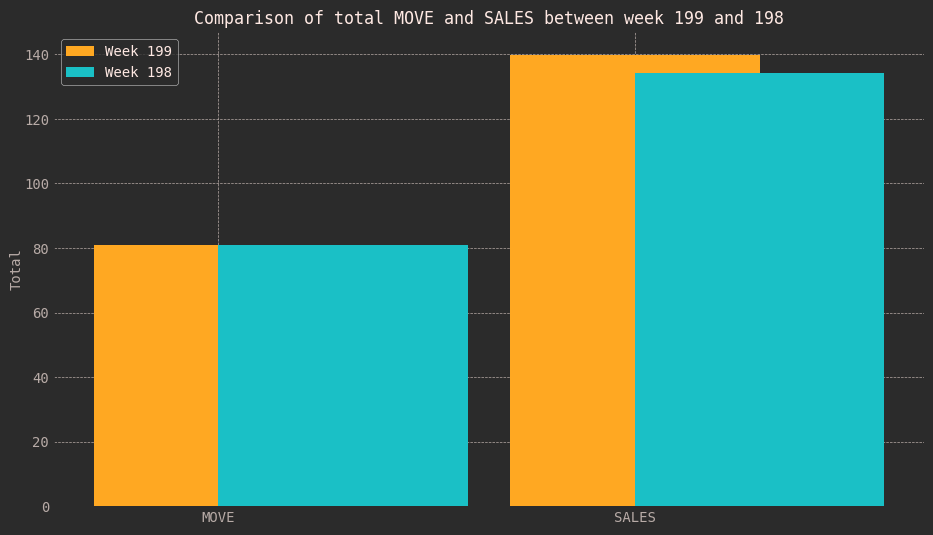

In [23]:
def compare_weeks(df, week1, week2):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    # Filter the data for the given weeks
    week1_data = df[df['WEEK'] == week1]
    week2_data = df[df['WEEK'] == week2]

    # Calculate the total 'MOVE' and 'SALES' for each week
    total_move_week1 = week1_data['MOVE'].sum()
    total_sales_week1 = week1_data['SALES'].sum()

    total_move_week2 = week2_data['MOVE'].sum()
    total_sales_week2 = week2_data['SALES'].sum()

    # Create a bar plot
    labels = ['MOVE', 'SALES']
    week1_totals = [total_move_week1, total_sales_week1]
    week2_totals = [total_move_week2, total_sales_week2]

    x = range(len(labels))  # the label locations

    plt.figure(figsize=(10, 6))
    plt.bar(x, week1_totals, width=0.6, label=f'Week {int(week1)}', align='center')
    plt.bar(x, week2_totals, width=0.6, label=f'Week {int(week2)}', align='edge')

    plt.xticks(x, labels)
    plt.ylabel('Total')
    plt.title(f'Comparison of total MOVE and SALES between week {int(week1)} and {int(week2)}')
    plt.legend()
    plt.show()
    
compare_weeks(df_week, most_frequent_week, most_frequent_week-1)

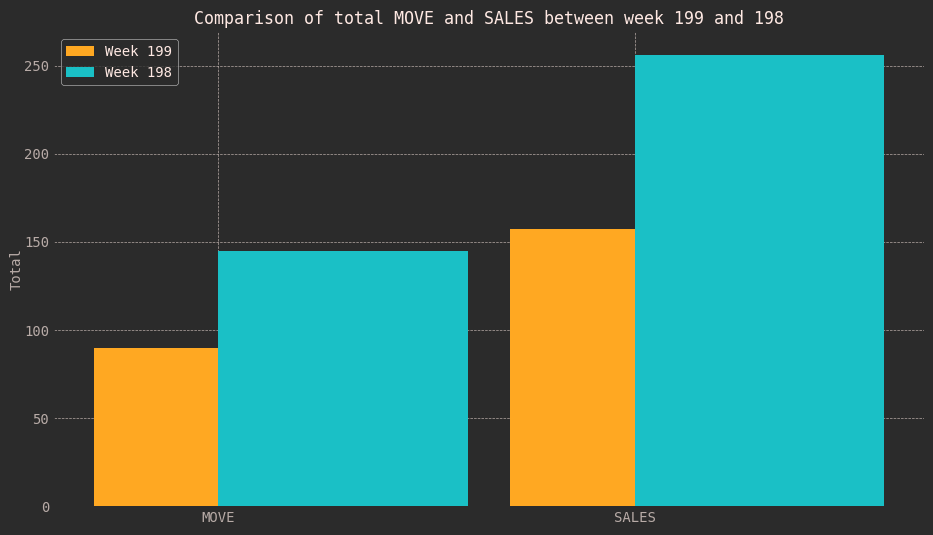

In [24]:
def compare_weeks(df, week1, week2):
    # Filter the data for the given weeks
    week1_data = df[df['WEEK'] == week1]
    week2_data = df[df['WEEK'] == week2]
    # Calculate the total 'MOVE' and 'SALES' for each week
    total_move_week1 = week1_data['MOVE'].sum()
    total_sales_week1 = week1_data['SALES'].sum()

    total_move_week2 = week2_data['MOVE'].sum()
    total_sales_week2 = week2_data['SALES'].sum()

    # Create a bar plot
    labels = ['MOVE', 'SALES']
    week1_totals = [total_move_week1, total_sales_week1]
    week2_totals = [total_move_week2, total_sales_week2]

    x = range(len(labels))  # the label locations

    plt.figure(figsize=(10, 6))
    plt.bar(x, week1_totals, width=0.6, label=f'Week {int(week1)}', align='center')
    plt.bar(x, week2_totals, width=0.6, label=f'Week {int(week2)}', align='edge')

    plt.xticks(x, labels)
    plt.ylabel('Total')
    plt.title(f'Comparison of total MOVE and SALES between week {int(week1)} and {int(week2)}')
    plt.legend()
    plt.show()
    
compare_weeks(df_week, most_frequent_week, most_frequent_week-1)

#### Sales comparison by category (Health and Beauty, Pharma, Health).

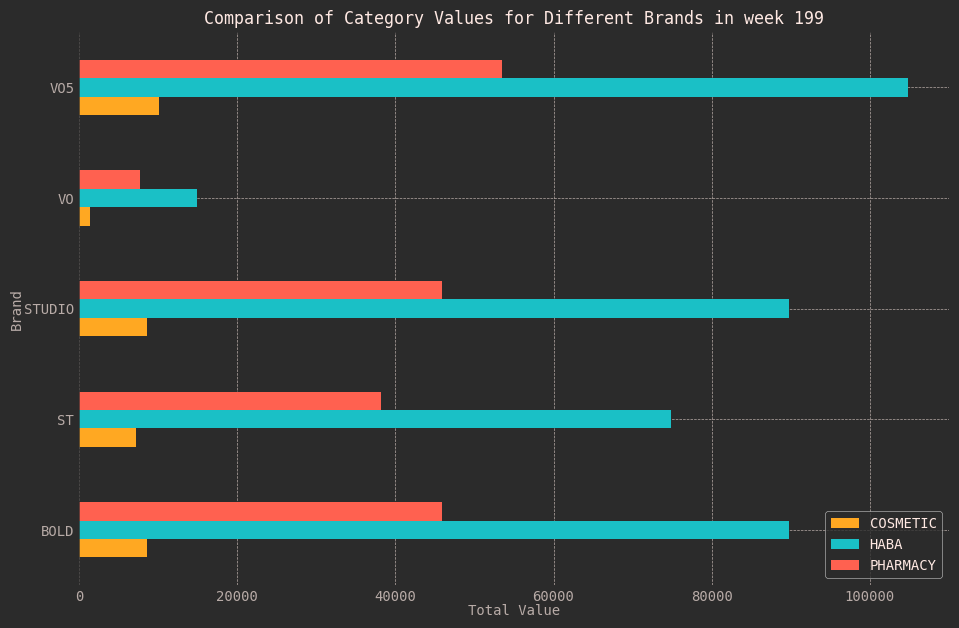

In [25]:
def horizontal_bar(df, week, selected_columns):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    week_data = df[df['WEEK'] == week]
    
    # Select only the specified columns
    df = week_data[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands in week {int(week)}')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["COSMETIC", "HABA","PHARMACY"]
horizontal_bar(df_week, most_frequent_week, selected_columns)

#### Sales and income comparison per brand of shampoo.

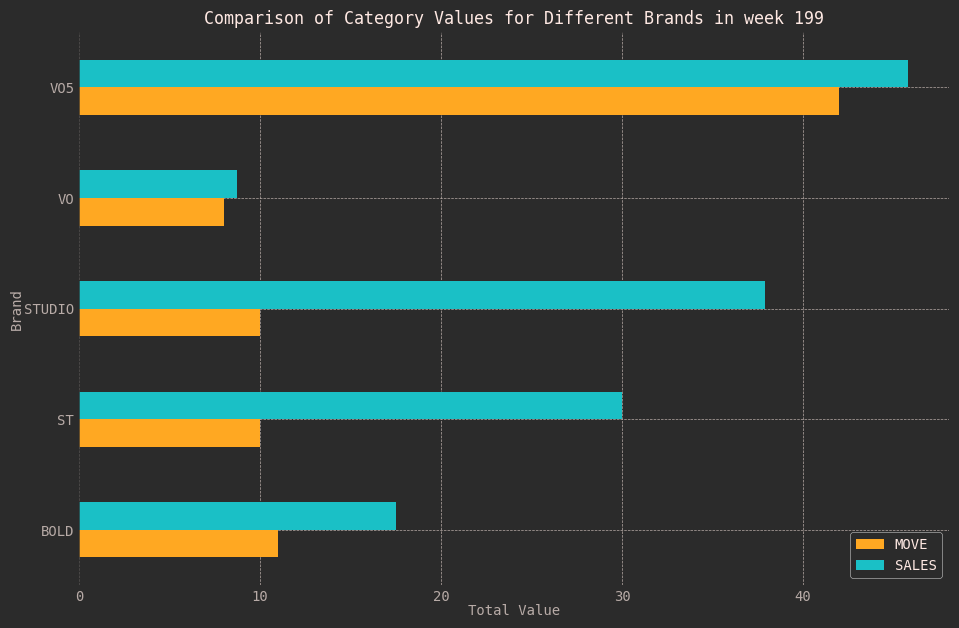

In [26]:
def horizontal_bar(df, week, selected_columns):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    week_data = df[df['WEEK'] == week]
    
    # Select only the specified columns
    df = week_data[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands in week {int(week)}')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["MOVE","SALES"]
horizontal_bar(df_week, most_frequent_week, selected_columns)

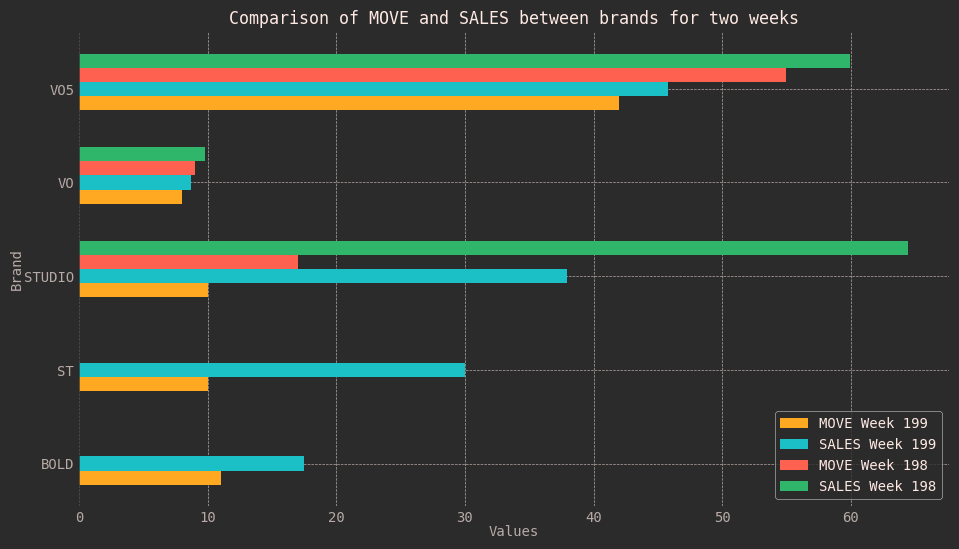

In [27]:
def horizontal_bar(df, week1, week2, selected_columns):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    week_data1 = df[df['WEEK'] == week1]
    week_data2 = df[df['WEEK'] == week2]
    
    # Select only the specified columns
    df_week1 = week_data1[selected_columns + ['BRAND']]
    df_week2 = week_data2[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals_week1 = df_week1.groupby("BRAND").sum()
    brand_totals_week2 = df_week2.groupby("BRAND").sum()

    # Width of the bars
    barWidth = 0.15
   
    # Position of bars on y-axis
    r1 = np.arange(len(brand_totals_week1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Plot grouped bars
    plt.figure(figsize=(10, 6))
    plt.barh(r1, brand_totals_week1['MOVE'], height=barWidth, label=f'MOVE Week {int(week1)}')
    plt.barh(r2, brand_totals_week1['SALES'], height=barWidth, label=f'SALES Week {int(week1)}')
    plt.barh(r3, brand_totals_week2['MOVE'], height=barWidth, label=f'MOVE Week {int(week2)}')
    plt.barh(r4, brand_totals_week2['SALES'], height=barWidth, label=f'SALES Week {int(week2)}')

    # Adding yticks
    plt.xlabel('Values')
    plt.yticks([r + barWidth for r in range(len(brand_totals_week1))], brand_totals_week1.index)
    plt.ylabel("Brand")
    plt.title("Comparison of MOVE and SALES between brands for two weeks")
    plt.legend()

    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["MOVE", "SALES"]
horizontal_bar(df_week, most_frequent_week, most_frequent_week-1, selected_columns)


#### Analysis of sales by customer type (women with kids under 6, women with kids under 17, and other).

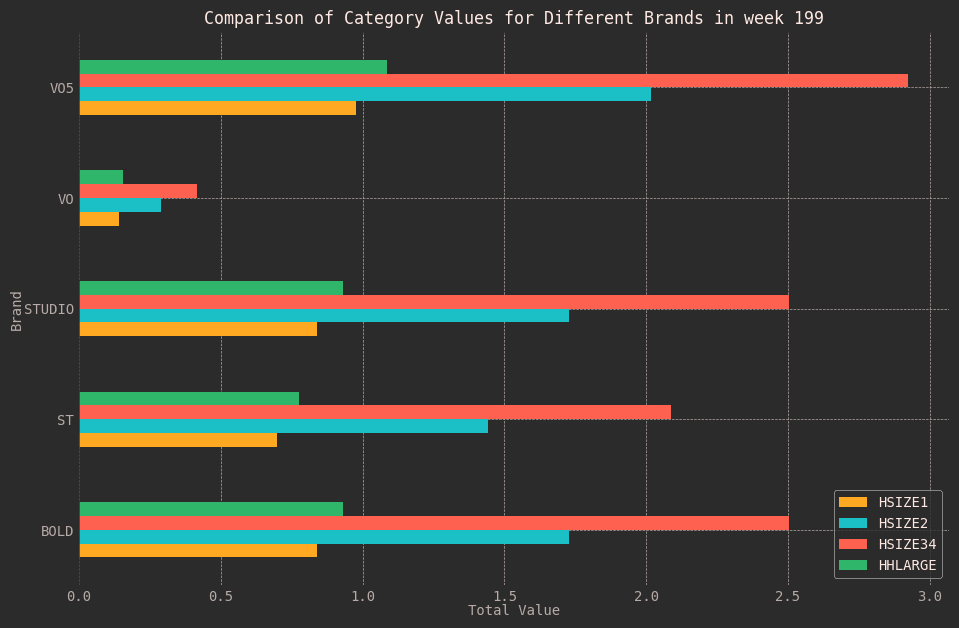

In [28]:
#"HSIZEAVG","HSIZE1","HSIZE2","HSIZE34","HHLARGE","SINGLE","RETIRED","UNEMP","WORKWOM","WRKCH5","WRKCH17","NWRKCH5","NWRKCH17","WRKCH","NWRKCH","WRKWNCH"

def horizontal_bar(df, week, selected_columns):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    week_data = df[df['WEEK'] == week]
    
    # Select only the specified columns
    df = week_data[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands in week {int(week)}')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["HSIZE1","HSIZE2","HSIZE34","HHLARGE"]
horizontal_bar(df_week, most_frequent_week, selected_columns)

This can be affected by bottle size, but that data whas lost when merging the brands.

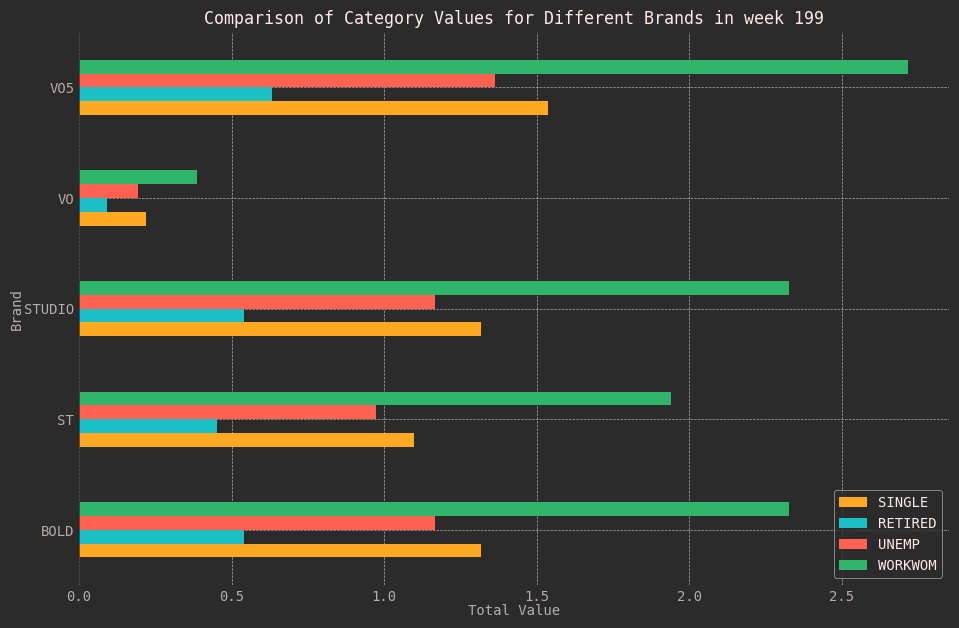

In [29]:
#"SINGLE","RETIRED","UNEMP","WORKWOM","WRKCH5","WRKCH17","NWRKCH5","NWRKCH17","WRKCH","NWRKCH","WRKWNCH"

def horizontal_bar(df, week, selected_columns):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    week_data = df[df['WEEK'] == week]
    
    # Select only the specified columns
    df = week_data[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands in week {int(week)}')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["SINGLE","RETIRED","UNEMP","WORKWOM"]
horizontal_bar(df_week, most_frequent_week, selected_columns)

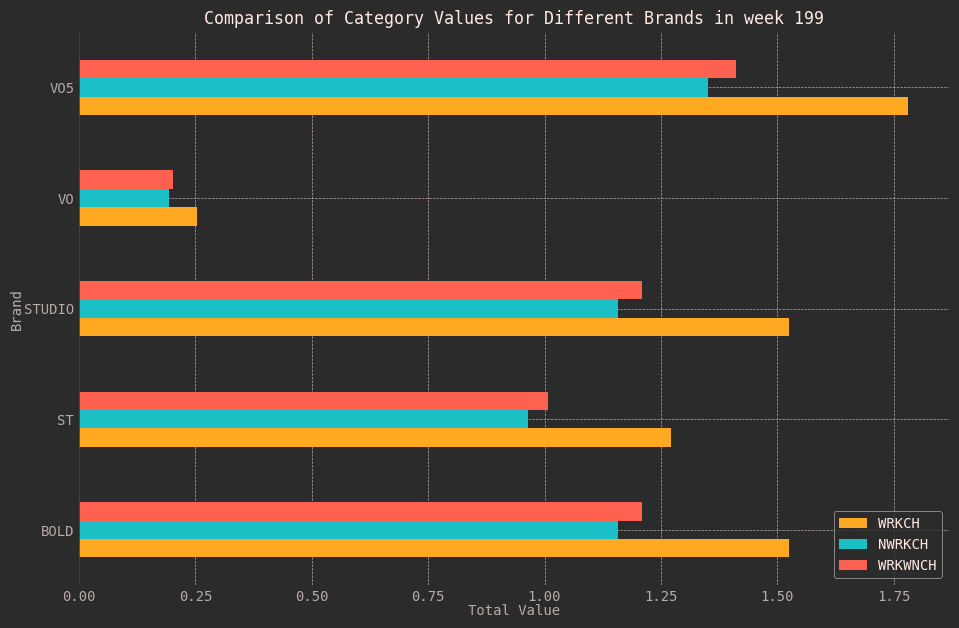

In [30]:
#"WORKWOM","WRKCH5","WRKCH17","NWRKCH5","NWRKCH17","WRKCH","NWRKCH","WRKWNCH"

def horizontal_bar(df, week, selected_columns):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    week_data = df[df['WEEK'] == week]
    
    # Select only the specified columns
    df = week_data[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands in week {int(week)}')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["WRKCH","NWRKCH","WRKWNCH"]
horizontal_bar(df_week, most_frequent_week, selected_columns)

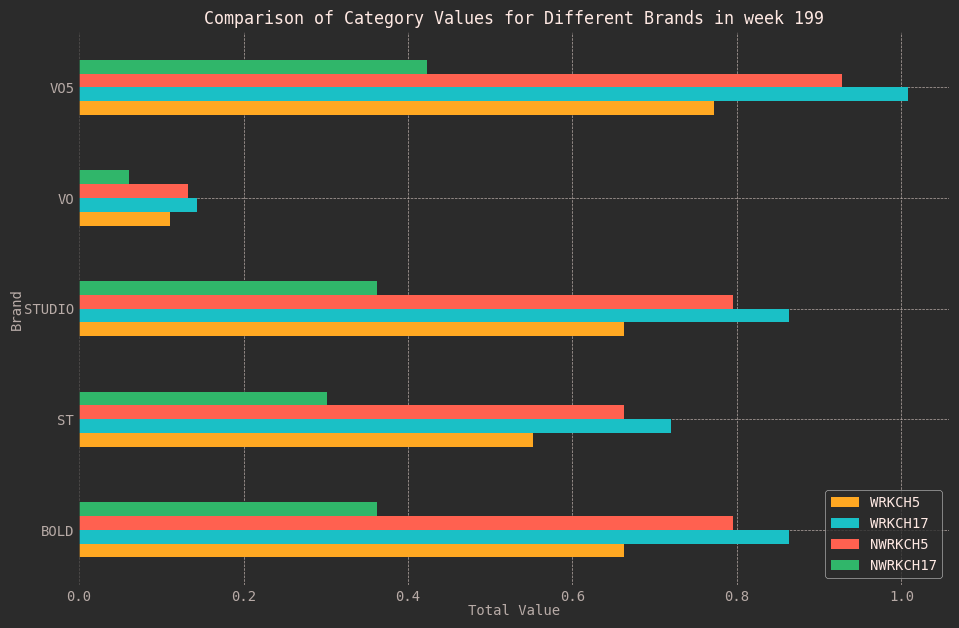

In [31]:
#"WORKWOM","WRKCH5","WRKCH17","NWRKCH5","NWRKCH17","WRKCH","NWRKCH","WRKWNCH"

def horizontal_bar(df, week, selected_columns):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    week_data = df[df['WEEK'] == week]
    
    # Select only the specified columns
    df = week_data[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands in week {int(week)}')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["WRKCH5","WRKCH17","NWRKCH5","NWRKCH17"]
horizontal_bar(df_week, most_frequent_week, selected_columns)

#### Brand vs. customer type vs. category analysis.

#### Trends in sales and income, overall and by customer type.

In [32]:
"""
def brand_trend_graph(df, selected_brands, max_week, column):
    # Filter out all brands that are not from the selected ones
    df = df[df['BRAND'].isin(selected_brands)]
    
    # Filter out all weeks that are more than max_week
    df = df[df['WEEK'] <= max_week]

    # Group by 'BRAND' and 'WEEK', calculate the sum of selected column
    grouped_df = df.groupby(['BRAND', 'WEEK'])[column].sum().reset_index()

    # Plotting
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=grouped_df, x='WEEK', y=column, hue='BRAND')
    plt.title(f'{column} Trend by Brand')
    plt.xlabel('Week')
    plt.ylabel(f'Total {column}')
    plt.show()

# Specify the brands you are interested in
selected_brands = ['VO5', 'VO', 'STUDIO', 'ST', 'BOLD']

input_file = "data_clean/shampoo_sale_data_brand.csv"

# Create new df because needing more week data
df_sale = pd.read_csv(input_file)
brand_trend_graph(df_sale, selected_brands, most_frequent_week, 'SALES')
brand_trend_graph(df_sale, selected_brands, most_frequent_week, 'MOVE')
"""

"""
def brand_trend_graph(df, selected_brands, min_week, max_week, column):
    # Filter out all brands that are not from the selected ones
    df = df[df['BRAND'].isin(selected_brands)]
    
    # Filter out all weeks that are not within the min_week and max_week
    df = df[(df['WEEK'] >= min_week) & (df['WEEK'] <= max_week)]

    # Group by 'BRAND' and 'WEEK', calculate the sum of selected column
    grouped_df = df.groupby(['BRAND', 'WEEK'])[column].sum().reset_index()

    # Plotting
    plt.figure(figsize=(15, 8))
    sns.regplot(x='WEEK', y=column, data=grouped_df)
    sns.lineplot(data=grouped_df, x='WEEK', y=column, hue='BRAND')
    plt.title(f'{column} Trend by Brand')
    plt.xlabel('Week')
    plt.ylabel(f'Total {column}')
    plt.show()

# Specify the brands you are interested in
selected_brands = ['*_AQUA', '*_IVORY', 'STUDIO', '*_STYLE', '*_SYYLE']

# Specify the brands you are interested in
selected_brands = ['VO5', 'VO', 'STUDIO', 'ST', 'BOLD']

input_file = "data_clean/shampoo_sale_data_brand.csv"

# Create new df because needing more week data
df_sale = pd.read_csv(input_file)
brand_trend_graph(df_sale, selected_brands, 173 ,most_frequent_week, 'SALES')
brand_trend_graph(df_sale, selected_brands, 173 ,most_frequent_week, 'MOVE')
"""

def brand_trend_graph(df, selected_brands, min_week, max_week, column, future_weeks):
    if (selected_brands is not None) and (type(selected_brands) != list):
        selected_brands = [selected_brands]
        
    # Filter out all brands that are not from the selected ones
    df = df[df["BRAND"].isin(selected_brands)]
    
    # Filter out all weeks that are not within the min_week and max_week
    df = df[(df["WEEK"] >= min_week) & (df["WEEK"] <= max_week)]

    # Group by 'BRAND' and 'WEEK', calculate the sum of selected column
    grouped_df = df.groupby(["BRAND", "WEEK"])[column].sum().reset_index()

    # Plotting
    plt.figure(figsize=(15, 8))

    # Plot each brand with its regression line
    for brand in selected_brands:
        brand_df = grouped_df[grouped_df["BRAND"] == brand]
        x = brand_df["WEEK"].values.reshape(-1, 1)
        y = brand_df[column].values
        reg = LinearRegression().fit(x, y)
        x_future = np.array(range(min_week, max_week + future_weeks + 1)).reshape(-1, 1)
        y_pred = reg.predict(x_future)
        plt.plot(x_future, y_pred, label=f"{brand} regression")
        plt.plot(x, y, label=f"{brand} data")
        plt.text(max_week + future_weeks, y_pred[-1], f"coefficient = {r2_score(y, reg.predict(x)):.2f}")

    # Plot a general regression line for all brands if there is more than one brand
    if len(selected_brands) > 1:
        x = grouped_df["WEEK"].values.reshape(-1, 1)
        y = grouped_df[column].values
        reg = LinearRegression().fit(x, y)
        x_future = np.array(range(min_week, max_week + future_weeks + 1)).reshape(-1, 1)
        y_pred = reg.predict(x_future)
        plt.plot(x_future, y_pred, 'w--', label='All brands regression')
        plt.scatter(x, y, label='All brands data')

    plt.title(f"{column} Trend by Brand")
    plt.xlabel("Week")
    plt.ylabel(f"Total {column}")
    plt.legend()
    plt.show()

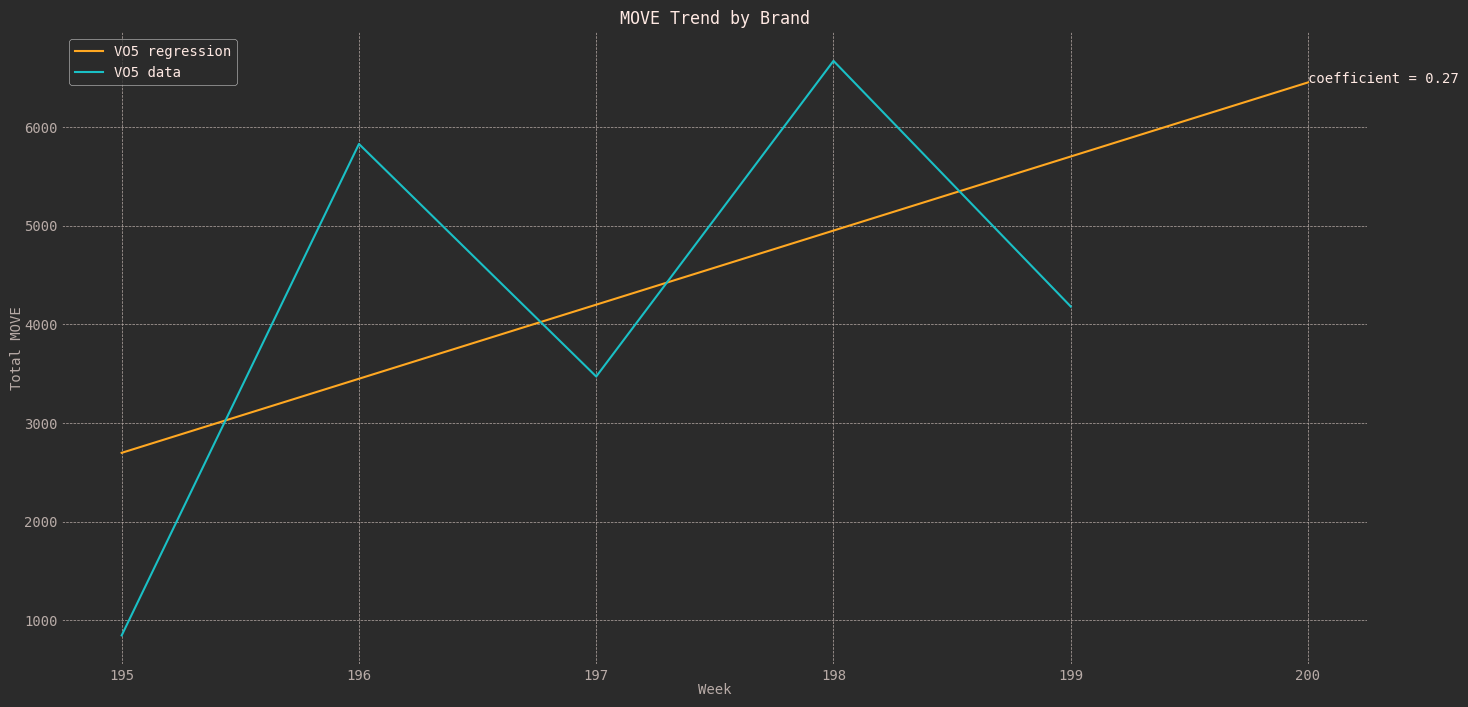

In [33]:
# Specify the brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][0]

# Category I want to predict
category = "MOVE"

# Create new df because needing more week data
input_file = "data_clean/shampoo_sale_data_brand.csv"
df_sale = pd.read_csv(input_file)

# Number of weeks I want to predict into the future
future_weeks = 1

brand_trend_graph(df_sale, selected_brands, int(195), int(most_frequent_week), category, int(future_weeks))

I have added some unesesety limits here, because as I understood the assignment, this part want ut to limit the amount of data used.
But it can be easely changed as seen in the next graph

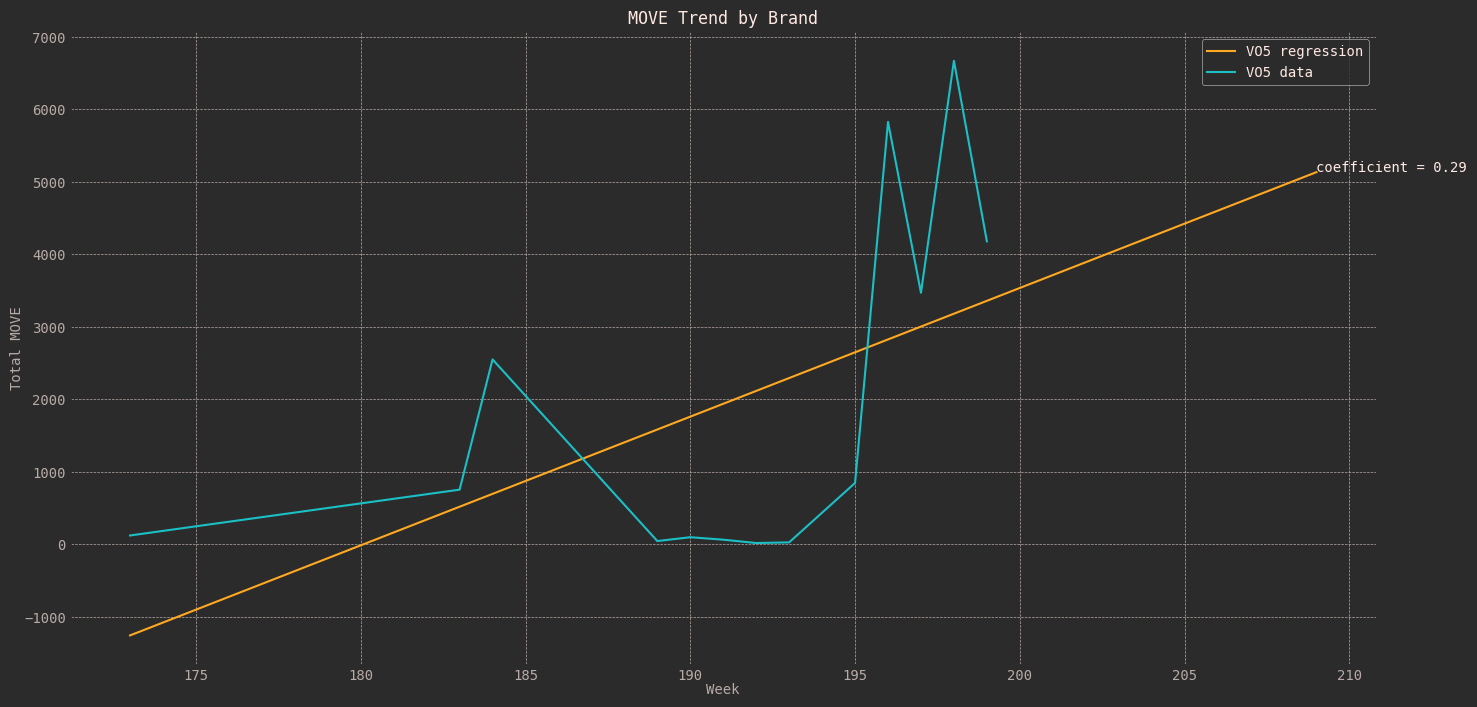

In [34]:
# Specify the brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][0]

# Category I want to predict
category = "MOVE"

# Create new df because needing more week data
input_file = "data_clean/shampoo_sale_data_brand.csv"
df_sale = pd.read_csv(input_file)

# Number of weeks I want to predict into the future
future_weeks = 10

brand_trend_graph(df_sale, selected_brands, int(173), int(most_frequent_week), category, int(future_weeks))

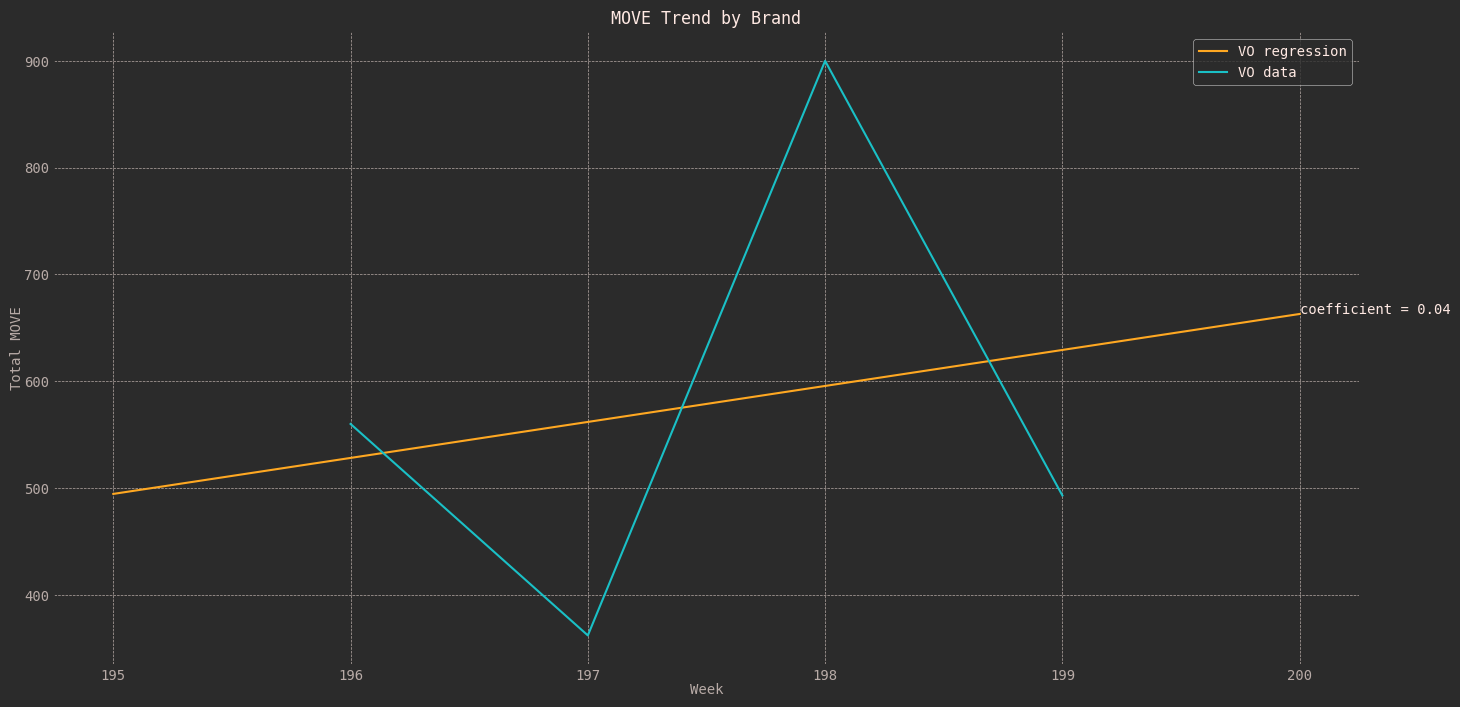

In [35]:
# Specify the brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][1]

# Category I want to predict
category = "MOVE"

# Create new df because needing more week data
input_file = "data_clean/shampoo_sale_data_brand.csv"
df_sale = pd.read_csv(input_file)

# Number of weeks I want to predict into the future
future_weeks = 1

brand_trend_graph(df_sale, selected_brands, int(195), int(most_frequent_week), category, int(future_weeks))

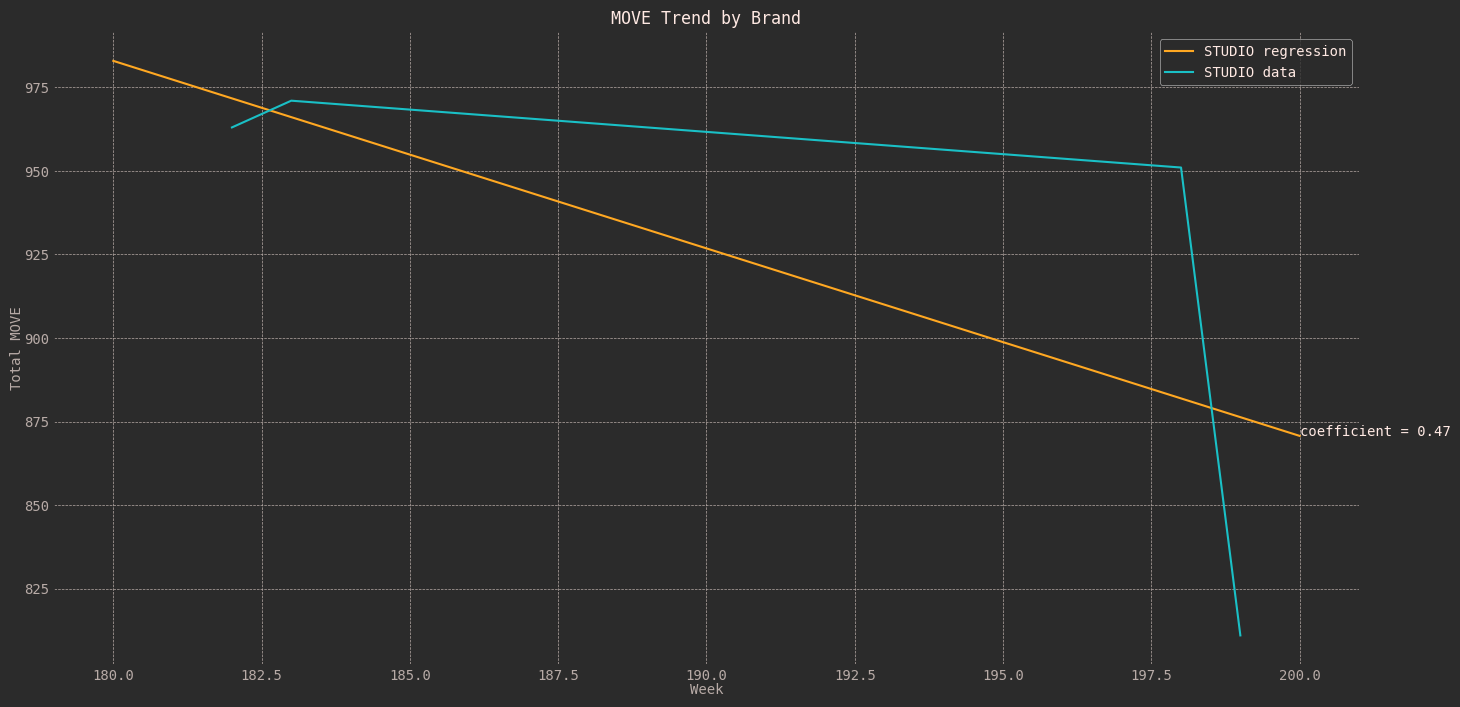

In [36]:
# Specify the brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][2]

# Category I want to predict
category = "MOVE"

# Create new df because needing more week data
input_file = "data_clean/shampoo_sale_data_brand.csv"
df_sale = pd.read_csv(input_file)

# Number of weeks I want to predict into the future
future_weeks = 1

brand_trend_graph(df_sale, selected_brands, int(180), int(most_frequent_week), category, int(future_weeks))

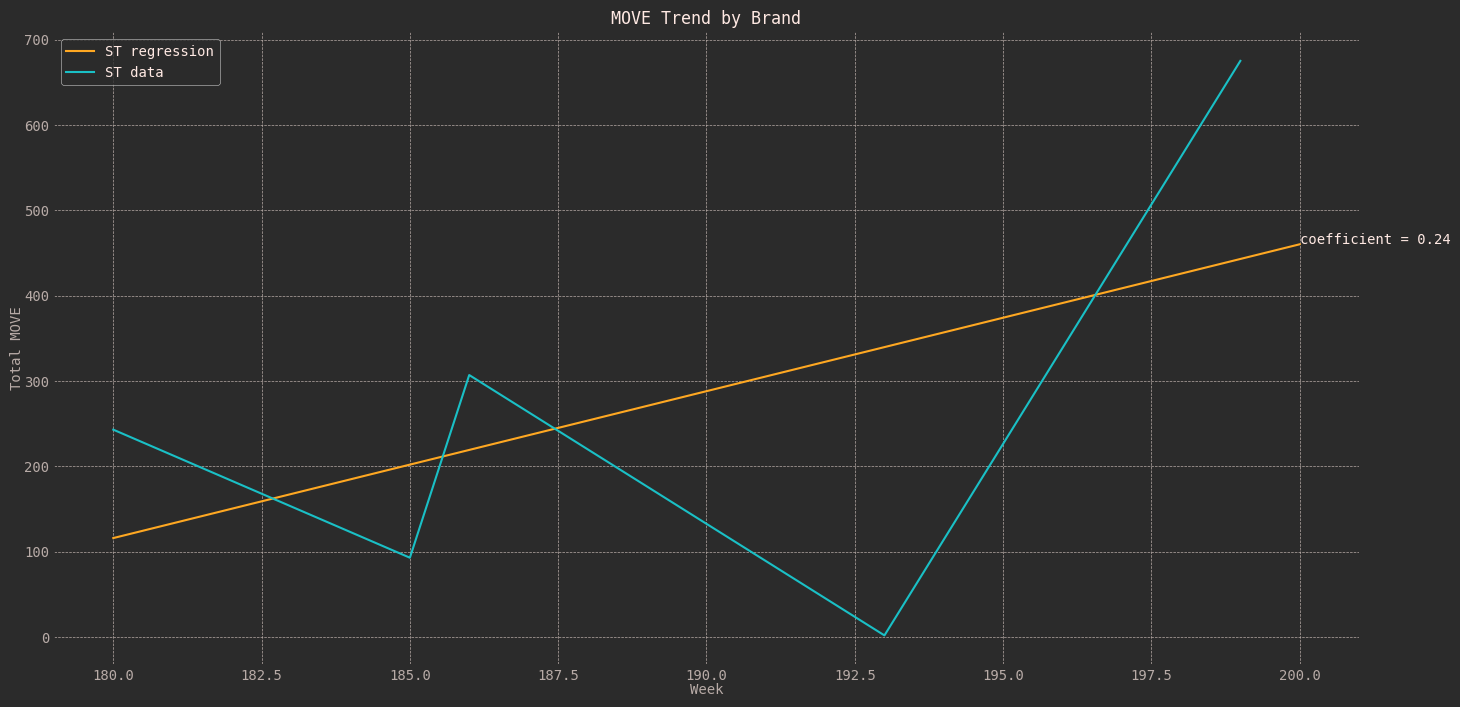

In [37]:
# Specify the brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][3]

# Category I want to predict
category = "MOVE"

# Create new df because needing more week data
input_file = "data_clean/shampoo_sale_data_brand.csv"
df_sale = pd.read_csv(input_file)

# Number of weeks I want to predict into the future
future_weeks = 1

brand_trend_graph(df_sale, selected_brands, int(180), int(most_frequent_week), category, int(future_weeks))

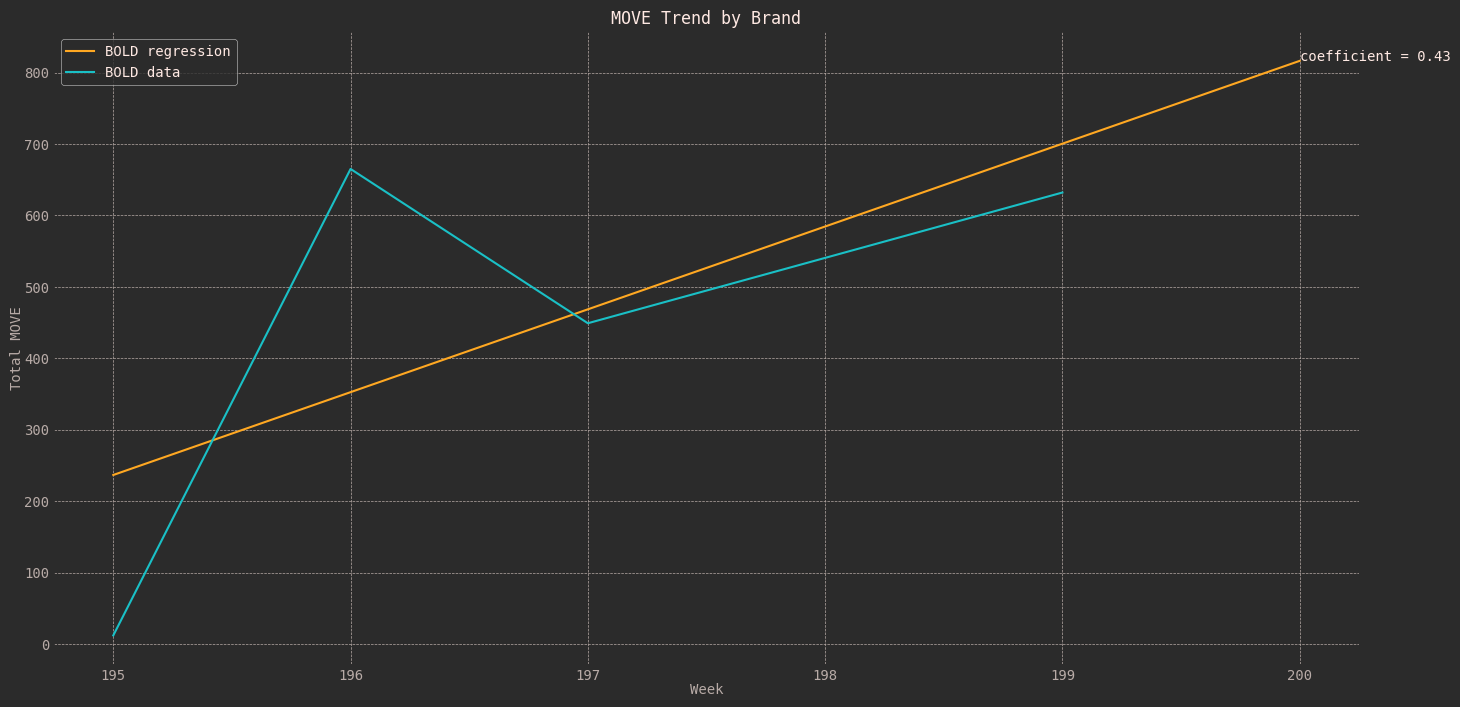

In [38]:
# Specify the brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][4]

# Category I want to predict
category = "MOVE"

# Create new df because needing more week data
input_file = "data_clean/shampoo_sale_data_brand.csv"
df_sale = pd.read_csv(input_file)

# Number of weeks I want to predict into the future
future_weeks = 1

brand_trend_graph(df_sale, selected_brands, int(195), int(most_frequent_week), category, int(future_weeks))

#### Trend analysis for individual shampoo brands.

#### Predictive analysis for next week's sales, income, and inventory levels.

### Monthly Report
----

#### Filter and create a data set for a monthly report

In [43]:
def group_by_week_and_convert_to_month(input_file, output_file, selected_brands = None):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_file)
    
    # Filter out all brands that are not in selected_brands if not None
    if selected_brands is not None:
        df = df[df["BRAND"].isin(selected_brands)]
    
    # Group the DataFrame by "WEEK", "UPC", and "STORE"
    grouped_df = df.groupby(["WEEK", "BRAND", "STORE"]).sum(numeric_only=True).reset_index()

    # Function to convert week encoding to month
    def week_to_month(week):
        start_date = datetime.strptime("1992-12-31", "%Y-%m-%d")
        week_173_date = start_date + timedelta(weeks=(week - 173))
        return week_173_date.month

    # Convert "WEEK" to "MONTHS" using the week_to_month function
    grouped_df["MONTHS"] = grouped_df["WEEK"].apply(week_to_month)

    # Drop the "WEEK" column
    grouped_df = grouped_df.drop(columns=["WEEK"])
    
    # Reorder columns to move "MONTHS" to the right of "STORE"
    new_column_order = ["BRAND", "STORE", "MONTHS"] + [col for col in grouped_df.columns if col not in ["BRAND", "STORE", "MONTHS"]]
    grouped_df = grouped_df.reindex(columns=new_column_order)

    # Save the grouped and modified DataFrame to a new CSV file
    grouped_df.to_csv(output_file, index=False)

    print(f"The file has been grouped and saved as {output_file}")
    
    
input_file = "data_clean/shampoo_sale_data_brand.csv"
output_file = "data_clean/month_shampoo_sale_data.csv"
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"]

time_function(group_by_week_and_convert_to_month,input_file, output_file, selected_brands)

The file has been grouped and saved as data_clean/month_shampoo_sale_data.csv
group_by_week_and_convert_to_month took 0.26 seconds to run.


In [83]:
# Load the data
input_file = "data_clean/month_shampoo_sale_data.csv"
df_month = pd.read_csv(input_file)

display(df_month)

,BRAND,STORE,MONTHS,MOVE,PRICE,QTY,PROFIT,CASE,COSMETIC,HABA,...,UNEMP,WORKWOM,WRKCH5,WRKCH17,NWRKCH5,NWRKCH17,WRKCH,NWRKCH,WRKWNCH,SALES
0,VO,5,12,1,1.59,1,44.03,12,0.000000,22718.31,...,0.177905,0.410568,0.058599,0.145191,0.108485,0.087790,0.203790,0.196275,0.272815,1.59
1,VO,12,12,2,1.59,1,44.03,12,0.000000,27835.07,...,0.203794,0.390942,0.050668,0.058338,0.046368,0.020569,0.109006,0.066938,0.333295,3.18
2,VO,32,12,1,1.59,1,44.03,12,0.000000,18254.81,...,0.162361,0.344152,0.030056,0.099460,0.058784,0.062956,0.129516,0.121741,0.300291,1.59
3,VO,45,12,2,1.59,1,44.03,12,0.000000,10975.55,...,0.151867,0.464113,0.071093,0.131414,0.108108,0.056013,0.202507,0.164121,0.318059,3.18
4,VO,47,12,1,1.59,1,44.03,12,0.000000,9294.90,...,0.168321,0.398027,0.059013,0.172810,0.089111,0.084883,0.231823,0.173994,0.248753,1.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,STUDIO,81,12,1,3.79,1,26.12,6,401.500000,15634.80,...,0.143096,0.429543,0.047978,0.142194,0.066454,0.070420,0.190172,0.136874,0.313671,3.79
3588,VO,95,12,1,1.29,1,64.65,12,53.130000,20169.15,...,0.187505,0.292846,0.035203,0.087931,0.055471,0.051966,0.123133,0.107437,0.274974,1.29
3589,VO5,77,12,5,2.93,2,137.64,24,903.020000,42511.72,...,0.364008,0.828328,0.144239,0.304694,0.224182,0.183499,0.448933,0.407681,0.493078,7.35
3590,VO5,93,12,8,3.02,2,129.48,24,252.040008,38934.84,...,0.395999,0.841275,0.096811,0.193854,0.087107,0.053835,0.290665,0.140943,0.696855,12.12


#### Graph and data on monthly sales, income, and inventory across all stores.

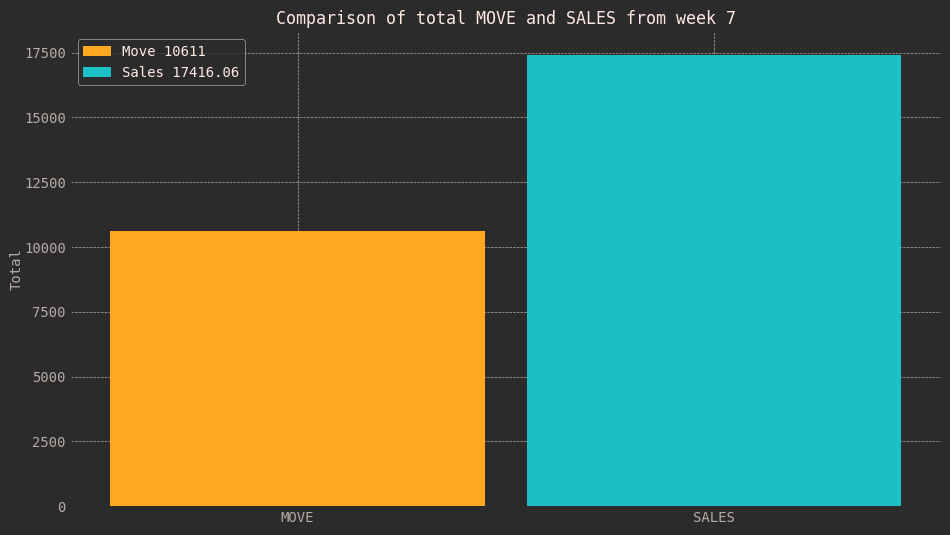

In [95]:
def compare_sale_and_move(df, month):
    # Filter out all brands that are not from the 5 selected
    df = brand_check(df)
    
    # Filter the data for the given weeks
    week1_data = df[df['MONTHS'] == month]

    # Calculate the total 'MOVE' and 'SALES' for each week
    total_move_week1 = week1_data['MOVE'].sum()
    total_sales_week1 = week1_data['SALES'].sum()

    # Create a bar plot
    labels = ['MOVE', 'SALES']
    week1_total_move = [total_move_week1, 0]
    week1_total_sale = [0, total_sales_week1]
    x = range(len(labels))  # the label locations

    plt.figure(figsize=(10, 6))
    plt.bar(x, week1_total_move, width=.9, label=f"Move {total_move_week1}", align='center')
    plt.bar(x, week1_total_sale, width=.9, label=f"Sales {total_sales_week1}", align='center')
    plt.xticks(x, labels)
    plt.ylabel('Total')
    plt.title(f'Comparison of total MOVE and SALES from week {month}')
    plt.legend()
    plt.show()

month = 7
compare_sale_and_move(df_month, month)

In [145]:
def horizontal_month_bar(df, month, selected_columns, group_selection):
    # Filter DataFrame to the selected month
    df = df[df['MONTHS'] == month]
    
    # Select only the specified columns plus 'STORE'
    df = df[selected_columns + ['STORE']]

    # Calculate the total for each selected column for each store
    store_totals = df.groupby("STORE").sum()
    
    # Calculate the total sum for each store across all selected columns
    store_totals['total'] = store_totals.sum(axis=1)
    
    # Change the height of the graph
    graph_height = 6
    
    if group_selection == 'top':
        # Select top 5 stores
        selected_stores = store_totals.head(5)
    elif group_selection == 'middle':
        # Select middle 5 stores
        selected_stores = store_totals.iloc[len(store_totals)//2 - 2 : len(store_totals)//2 + 3]
    elif group_selection == 'bottom':
        # Select bottom 5 stores
        selected_stores = store_totals.tail(5)
    elif group_selection == 'all':
        # Select all stores
        selected_stores = store_totals
        graph_height = 40 # change the graph size
    else:
        raise ValueError(f"Invalid selection: {group_selection}. Choose from 'top', 'middle', 'bottom', or 'all'.")

    # Width of the bars
    barWidth = 0.3
   
    # Position of bars on y-axis
    r1 = np.arange(len(selected_stores))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Plot grouped bars
    plt.figure(figsize=(10, graph_height))
    plt.barh(r1, selected_stores['MOVE'], height=barWidth, label=f'MOVE Month {int(month)}')
    plt.barh(r2, selected_stores['SALES'], height=barWidth, label=f'SALES Month {int(month)}')

    # Adding yticks
    plt.xlabel('Values')
    plt.yticks([r + barWidth for r in range(len(selected_stores))], selected_stores.index)
    plt.ylabel("STORE code")
    plt.title(f"Comparison of MOVE and SALES between {group_selection} stores for Month {int(month)}")
    plt.legend()

    plt.show()

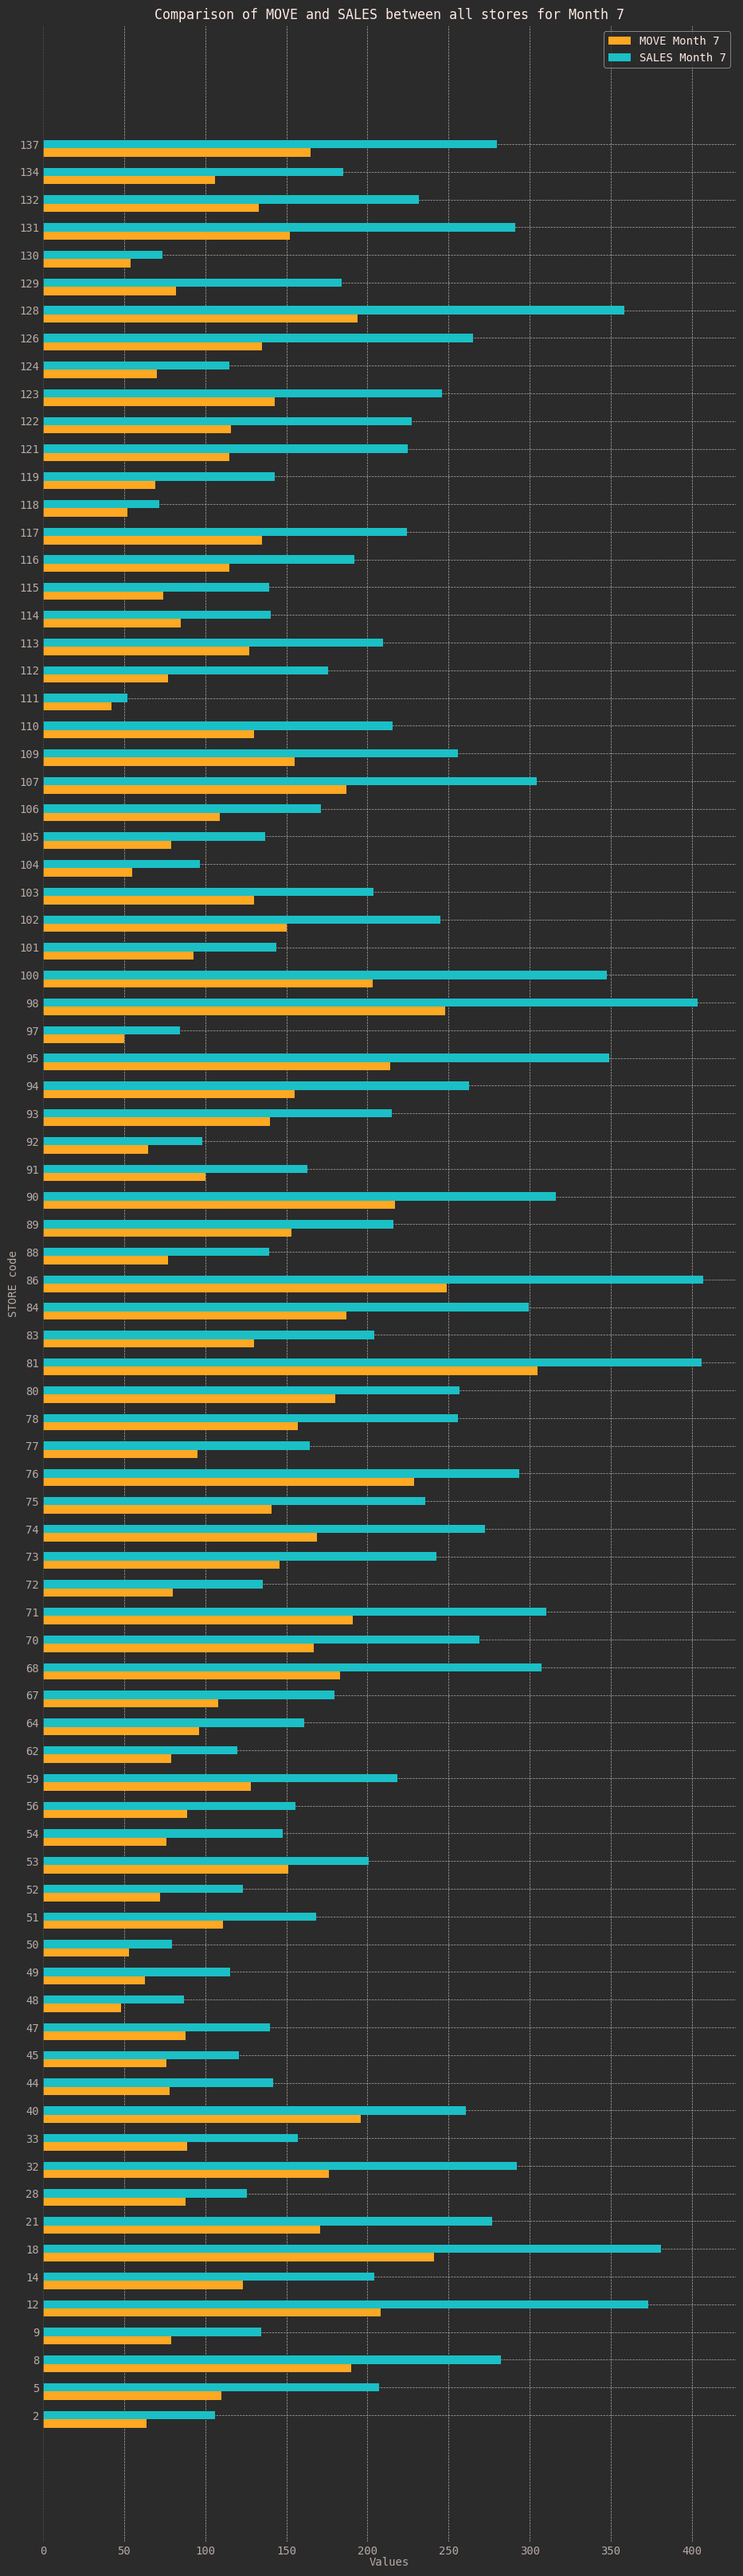

In [146]:
# Specify the columns to include in your graph
selected_columns = ["MOVE", "SALES"]

# Store selection - choose from 'top', 'middle', 'bottom', or 'all'
selection = 'all'
horizontal_month_bar(df_month, month, selected_columns, selection)

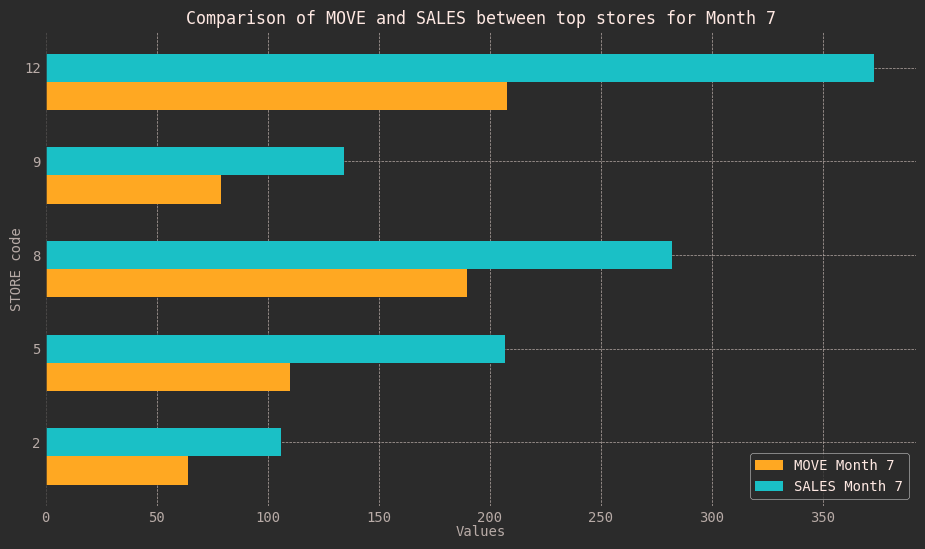

In [147]:
# Columns to include in the graph
selected_columns = ["MOVE", "SALES"]

# Store selection - choose from 'top', 'middle', 'bottom', or 'all'
selection = 'top'
horizontal_month_bar(df_month, month, selected_columns, selection)

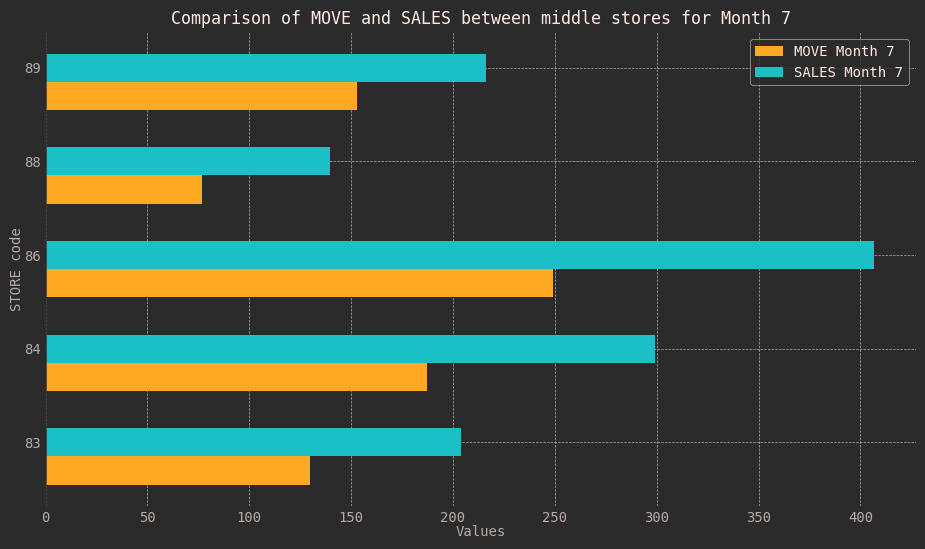

In [148]:
# Columns to include in the graph
selected_columns = ["MOVE", "SALES"]

# Store selection - choose from 'top', 'middle', 'bottom', or 'all'
selection = 'middle'
horizontal_month_bar(df_month, month, selected_columns, selection)

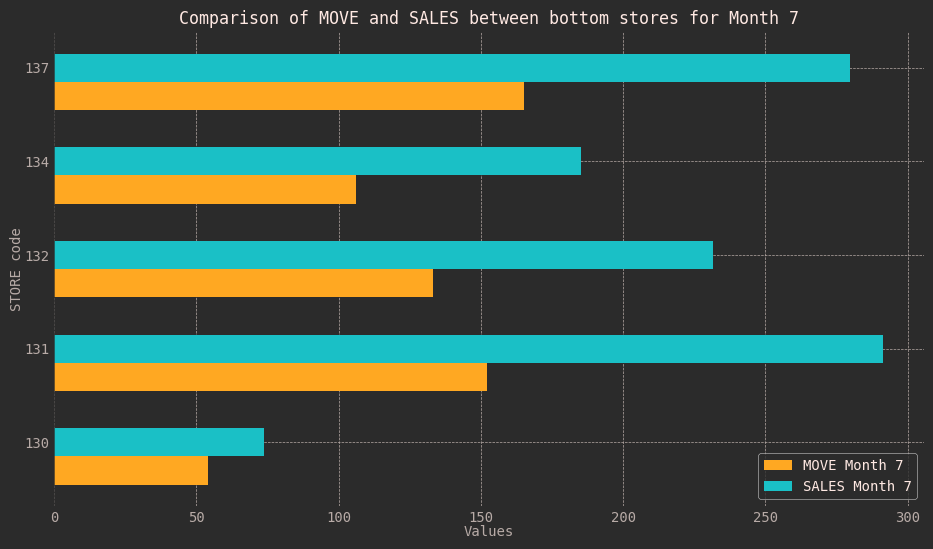

In [149]:
# Columns to include in the graph
selected_columns = ["MOVE", "SALES"]

# Store selection - choose from 'top', 'middle', 'bottom', or 'all'
selection = 'bottom'
horizontal_month_bar(df_month, month, selected_columns, selection)

#### Month-over-month comparison of sales and income.

In [154]:
def line_graph(df, column, selection):
    # Group DataFrame by 'MONTHS' and 'STORE'
    df_grouped = df.groupby(['MONTHS', 'STORE'])[column].sum().unstack()

    if isinstance(selection, list):
        # If the selection is a list of specific values
        df_grouped = df_grouped[selection]
    else:
        if selection == 'all':
            pass
        elif selection == 'top':
            # Select top 5 stores
            top_5_stores = df_grouped.iloc[-1].nlargest(5).index
            df_grouped = df_grouped[top_5_stores]
        elif selection == 'middle':
            # Select middle 5 stores
            middle_5_stores = df_grouped.iloc[-1].sort_values().iloc[len(df_grouped)//2 - 2 : len(df_grouped)//2 + 3].index
            df_grouped = df_grouped[middle_5_stores]
        elif selection == 'bottom':
            # Select bottom 5 stores
            bottom_5_stores = df_grouped.iloc[-1].nsmallest(5).index
            df_grouped = df_grouped[bottom_5_stores]
        else:
            raise ValueError(f"Invalid selection: {selection}. Choose from 'top', 'middle', 'bottom', or a list of store codes.")
    
    # Plotting
    plt.figure(figsize=(15, 8))
    for store in df_grouped.columns:
        plt.plot(df_grouped.index, df_grouped[store], label=f'Store {store}')
        
    plt.title(f'{column} Trend by Store')
    plt.xlabel('Month')
    plt.ylabel(f'Total {column}')
    plt.legend()
    plt.show()

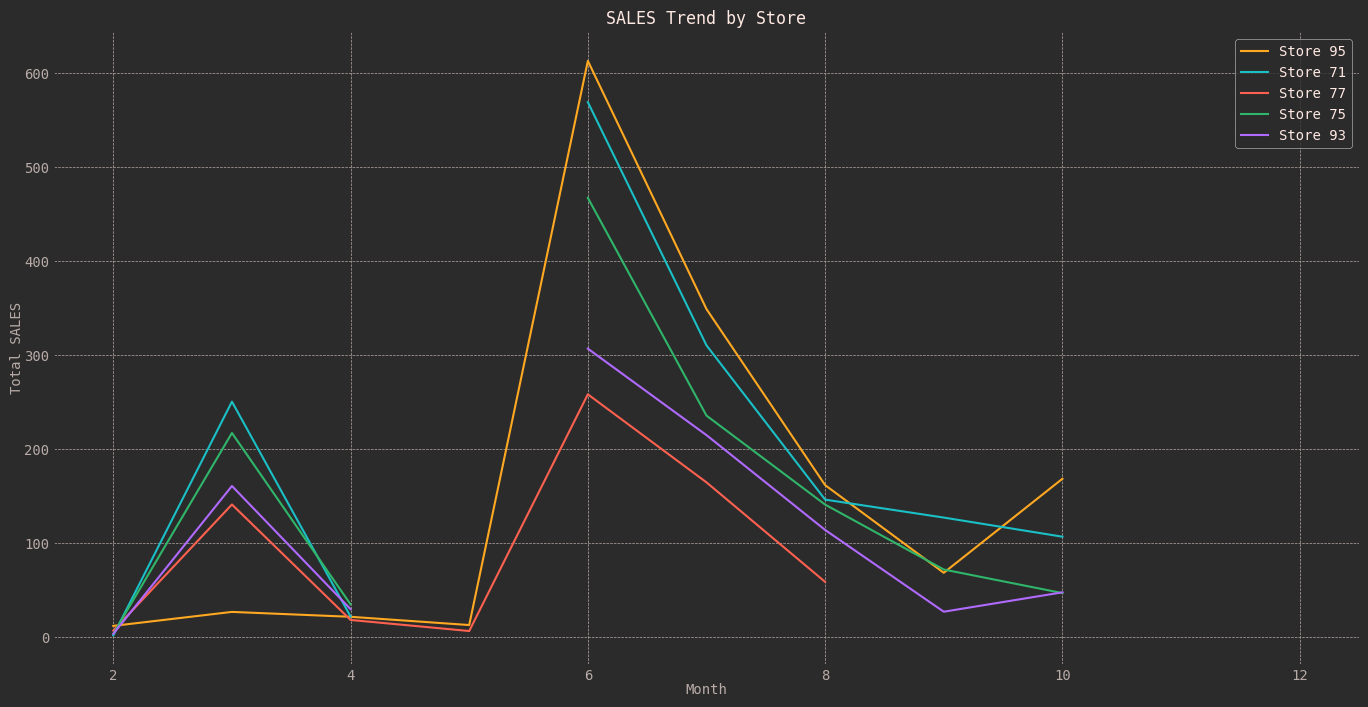

In [160]:
# Columns to include in the graph
column = 'SALES'
# Store selection - choose from 'top', 'middle', 'bottom', or a list of store codes
selection = 'top'
line_graph(df_month, column, selection)

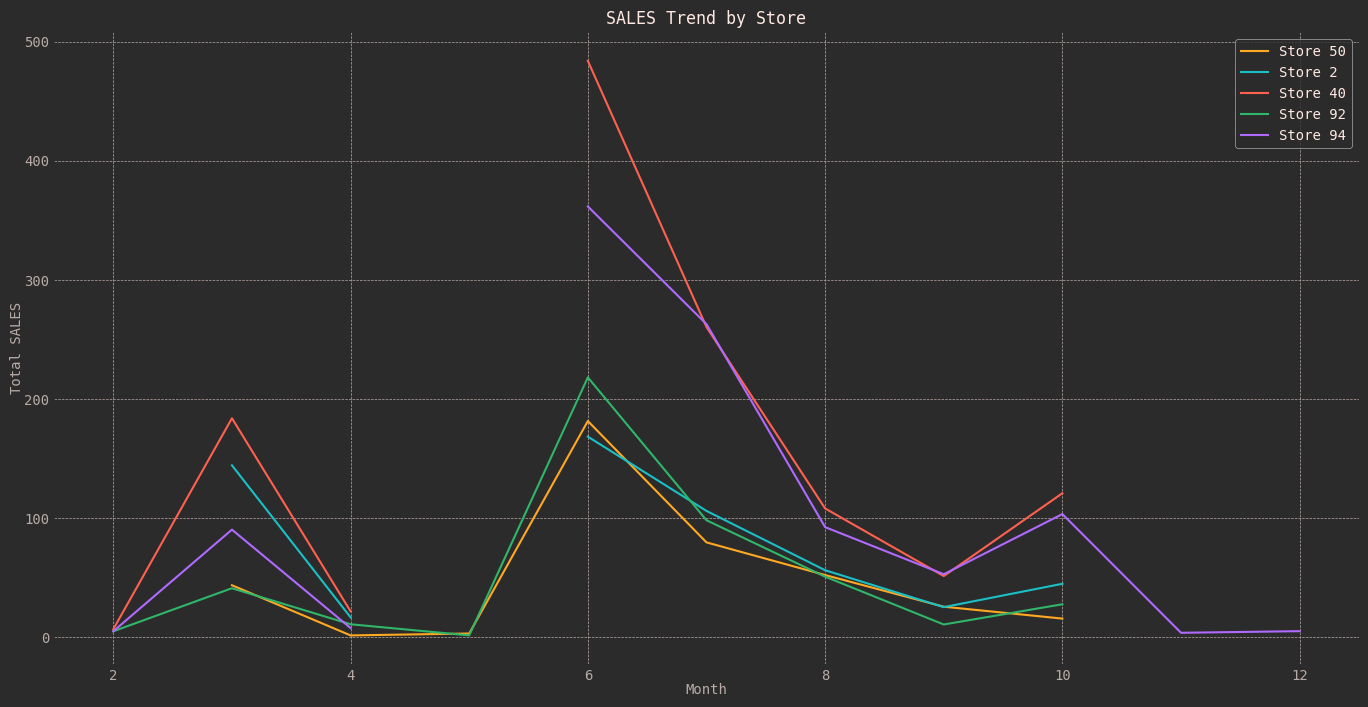

In [158]:
# Columns to include in the graph
column = 'SALES'
# Store selection - choose from 'top', 'middle', 'bottom', or a list of store codes
selection = 'bottom'
line_graph(df_month, column, selection)

#### Comparison of sales performance across different stores.

In [ ]:
def horizontal_month_bar(df, month, selected_columns, group_selection):
    # Filter DataFrame to the selected month
    df = df[df['MONTHS'] == month]
    
    # Select only the specified columns plus 'STORE'
    df = df[selected_columns + ['STORE']]

    # Calculate the total for each selected column for each store
    store_totals = df.groupby("STORE").sum()
    
    # Calculate the total sum for each store across all selected columns
    store_totals['total'] = store_totals.sum(axis=1)
    
    # Change the height of the graph
    graph_height = 6
    
    if group_selection == 'top':
        # Select top 5 stores
        selected_stores = store_totals.head(5)
    elif group_selection == 'middle':
        # Select middle 5 stores
        selected_stores = store_totals.iloc[len(store_totals)//2 - 2 : len(store_totals)//2 + 3]
    elif group_selection == 'bottom':
        # Select bottom 5 stores
        selected_stores = store_totals.tail(5)
    elif group_selection == 'all':
        # Select all stores
        selected_stores = store_totals
        graph_height = 40 # change the graph size
    else:
        raise ValueError(f"Invalid selection: {group_selection}. Choose from 'top', 'middle', 'bottom', or 'all'.")

    # Width of the bars
    barWidth = 0.3
   
    # Position of bars on y-axis
    r1 = np.arange(len(selected_stores))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Plot grouped bars
    plt.figure(figsize=(10, graph_height))
    plt.barh(r1, selected_stores['MOVE'], height=barWidth, label=f'MOVE Month {int(month)}')
    plt.barh(r2, selected_stores['SALES'], height=barWidth, label=f'SALES Month {int(month)}')

    # Adding yticks
    plt.xlabel('Values')
    plt.yticks([r + barWidth for r in range(len(selected_stores))], selected_stores.index)
    plt.ylabel("STORE code")
    plt.title(f"Comparison of MOVE and SALES between {group_selection} stores for Month {int(month)}")
    plt.legend()

    plt.show()

#### Sales comparison by category (Health and Beauty, Pharma, Health).

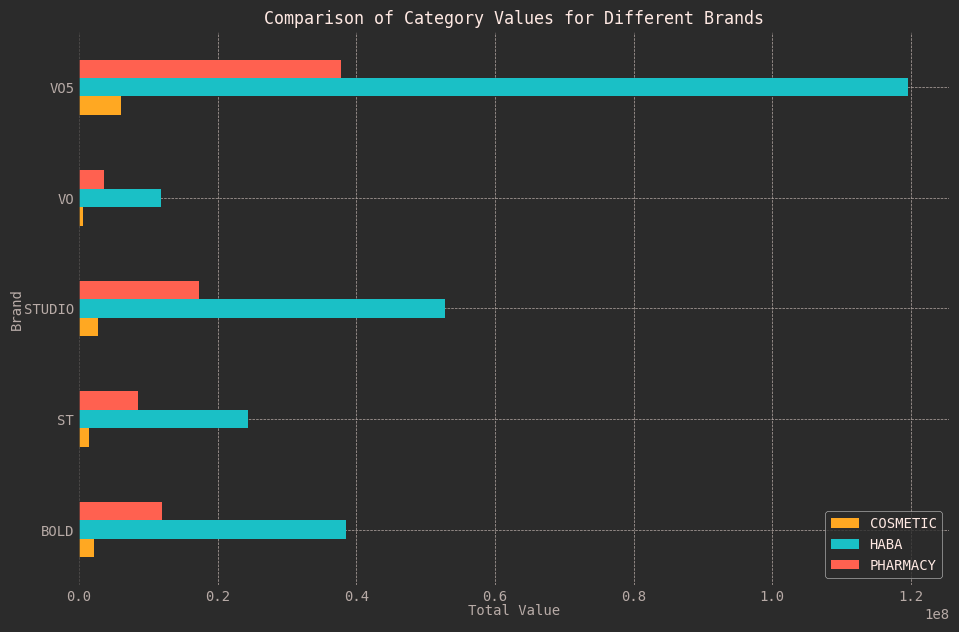

In [163]:
def horizontal_bar(df, selected_columns):
        
    # Select only the specified columns
    df = df[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Columns to include in the graph
selected_columns = ["COSMETIC", "HABA","PHARMACY"]
horizontal_bar(df_month, selected_columns)

#### Sales and income comparison per brand of shampoo across all stores.

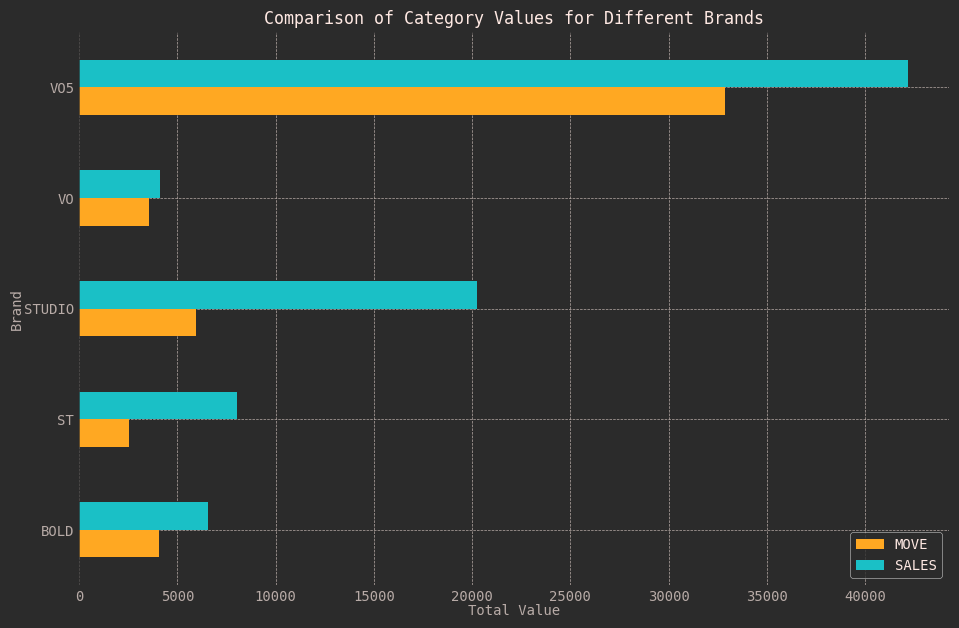

In [164]:
def horizontal_bar(df, selected_columns):
        
    # Select only the specified columns
    df = df[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["MOVE","SALES"]
horizontal_bar(df_month, selected_columns)

#### House Size

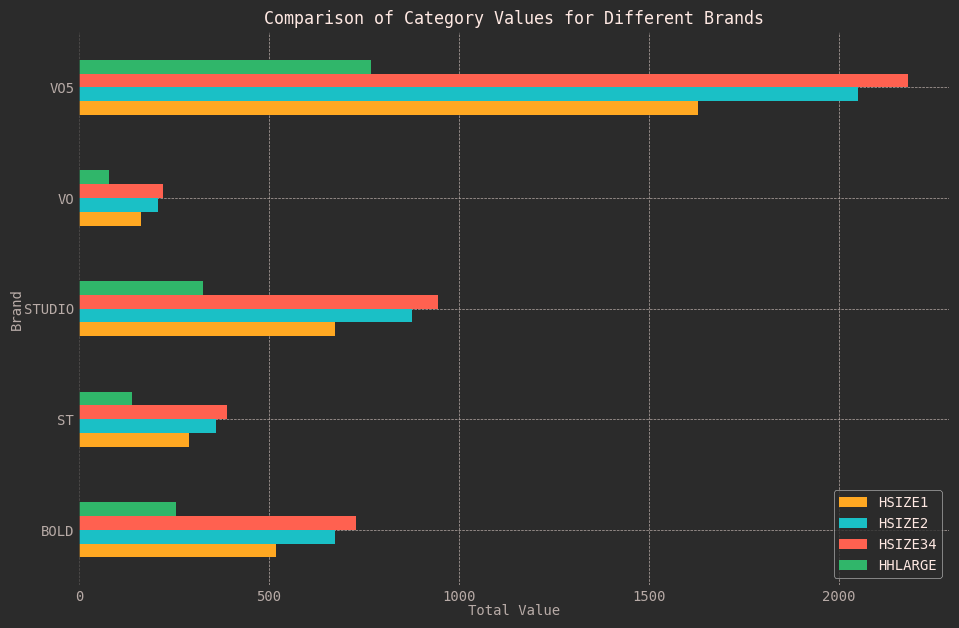

In [165]:
def horizontal_bar(df, selected_columns):
        
    # Select only the selected columns
    df = df[selected_columns + ['BRAND']]

    # Calculate the total for each chategory column for each brand
    brand_totals = df.groupby("BRAND").sum()

    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["HSIZE1","HSIZE2","HSIZE34","HHLARGE"]
horizontal_bar(df_month, selected_columns)

#"HSIZEAVG","HSIZE1","HSIZE2","HSIZE34","HHLARGE","SINGLE","RETIRED","UNEMP","WORKWOM","WRKCH5","WRKCH17","NWRKCH5","NWRKCH17","WRKCH","NWRKCH","WRKWNCH"

#### Analysis of sales by customer type (women with kids under 6, women with kids under 17, and other).

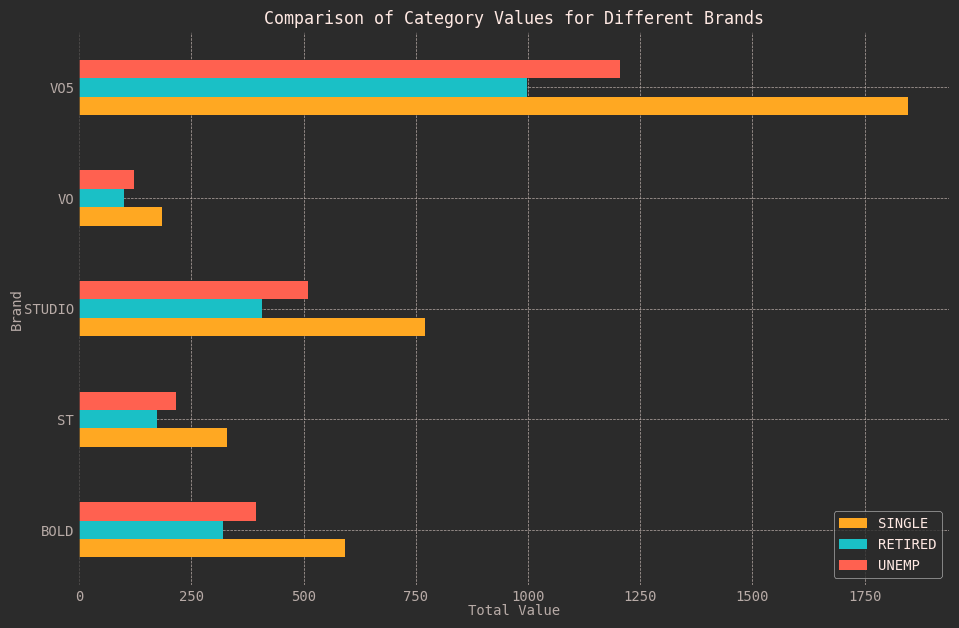

In [166]:
def horizontal_bar(df, selected_columns):
        
    # Select only the selected columns
    df = df[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["SINGLE","RETIRED","UNEMP"]
horizontal_bar(df_month, selected_columns)

#"HSIZEAVG","HSIZE1","HSIZE2","HSIZE34","HHLARGE","SINGLE","RETIRED","UNEMP","WORKWOM","WRKCH5","WRKCH17","NWRKCH5","NWRKCH17","WRKCH","NWRKCH","WRKWNCH"

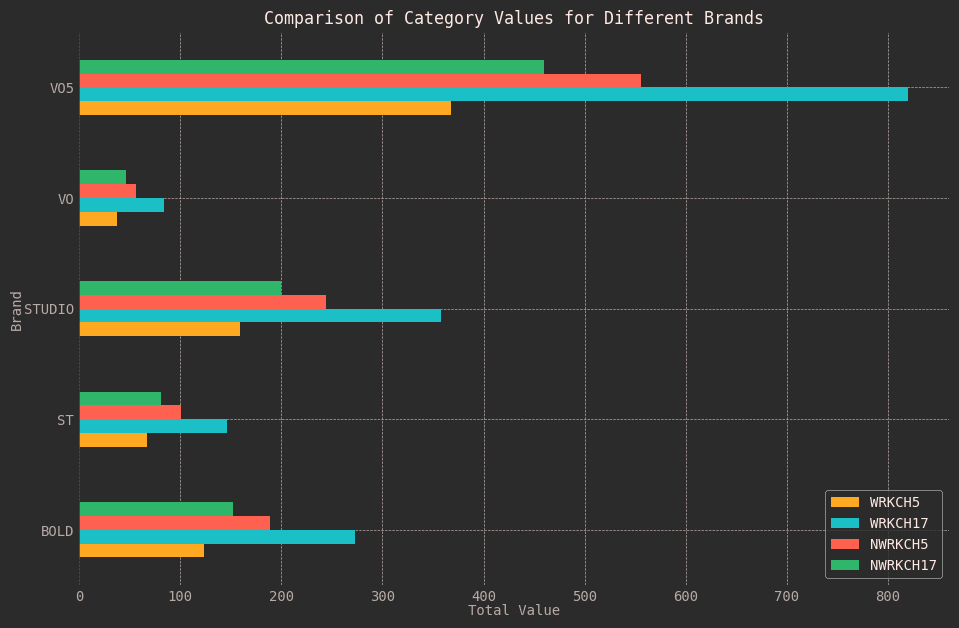

In [167]:
def horizontal_bar(df, selected_columns):
        
    # Select only the selected columns
    df = df[selected_columns + ['BRAND']]

    # Calculate the total for each category column for each brand
    brand_totals = df.groupby("BRAND").sum()

    # Plot a horizontal bar graph
    brand_totals.plot(kind='barh', figsize=(10, 7))
    plt.title(f'Comparison of Category Values for Different Brands')
    plt.xlabel('Total Value')
    plt.ylabel('Brand')
    plt.show()

# Specify the columns you want to include in your graph
selected_columns = ["WRKCH5","WRKCH17","NWRKCH5","NWRKCH17"]
horizontal_bar(df_month, selected_columns)

#"HSIZEAVG","HSIZE1","HSIZE2","HSIZE34","HHLARGE","SINGLE","RETIRED","UNEMP","WORKWOM","WRKCH5","WRKCH17","NWRKCH5","NWRKCH17","WRKCH","NWRKCH","WRKWNCH"

#### Trend analysis

In [203]:
def brand_trend_graph(df, selected_brands, min_month, max_month, column, future_months):
    if (selected_brands is not None) and (type(selected_brands) != list):
        selected_brands = [selected_brands]

    # Filter out all brands that are not from the selected ones
    df = df[df["BRAND"].isin(selected_brands)]
    
    # Filter out all months that are not within the min_month and max_month
    df = df[(df["MONTHS"] >= min_month) & (df["MONTHS"] <= max_month)]

    # Group by 'BRAND' and 'MONTHS', calculate the sum of selected column
    grouped_df = df.groupby(["BRAND", "MONTHS"])[column].sum().reset_index()

    # Plotting
    plt.figure(figsize=(15, 8))

    # Plot each brand with its regression line
    for brand in selected_brands:
        brand_df = grouped_df[grouped_df["BRAND"] == brand]
        x = brand_df["MONTHS"].values.reshape(-1, 1)
        y = brand_df[column].values
        reg = LinearRegression().fit(x, y)
        x_future = np.array(range(min_month, max_month + future_months + 1)).reshape(-1, 1)
        y_pred = reg.predict(x_future)
        plt.plot(x_future, y_pred, label=f"{brand} regression")
        plt.plot(x, y, label=f"{brand} data")
        slope = reg.coef_[0] # slope of the line

        # Calculate the percentage change per month in the dependent variable
        initial_value = y[0]
        final_value = y[-1]
        percentage_change_per_month = ((final_value - initial_value) / initial_value) * 100 / len(y)
        plt.text(max_month + future_months, y_pred[-1], f"coefficient = {r2_score(y, reg.predict(x)):.2f}\nPercentage change per month = {percentage_change_per_month:.2f}%")
        #plt.text(max_month + future_months, y_pred[-1] - 0.05, f"Percentage change per month = {percentage_change_per_month:.2f}%")


    # Plot a general regression line for all brands if there is more than one brand
    if len(selected_brands) > 1:
        x = grouped_df["MONTHS"].values.reshape(-1, 1)
        y = grouped_df[column].values
        reg = LinearRegression().fit(x, y)
        x_future = np.array(range(min_month, max_month + future_months + 1)).reshape(-1, 1)
        y_pred = reg.predict(x_future)
        plt.plot(x_future, y_pred, 'w--', label='All brands regression')
        plt.scatter(x, y, label='All brands data')

    plt.title(f"{column} Trend by Brand")
    plt.xlabel("Month")
    plt.ylabel(f"Total {column}")
    plt.legend()
    plt.show()

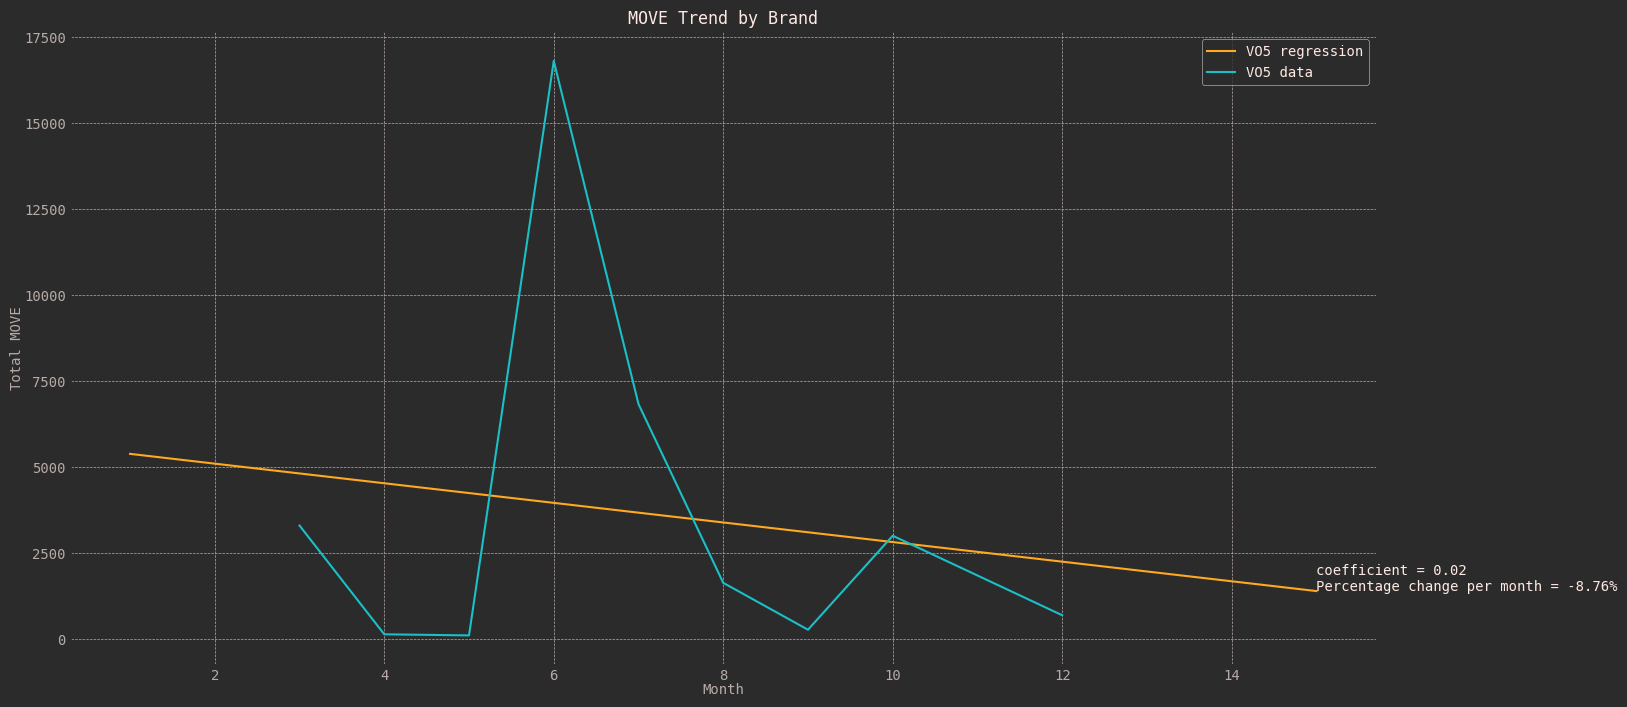

In [204]:
# Brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][0]

# Category I want to predict
category = "MOVE"

# Create new df because needing more month data
input_file = "data_clean/month_shampoo_sale_data.csv"
df_sale = pd.read_csv(input_file)

# Number of months I want to predict into the future
future_months = 3

brand_trend_graph(df_sale, selected_brands, min_month=1, max_month=12, column=category, future_months=future_months)

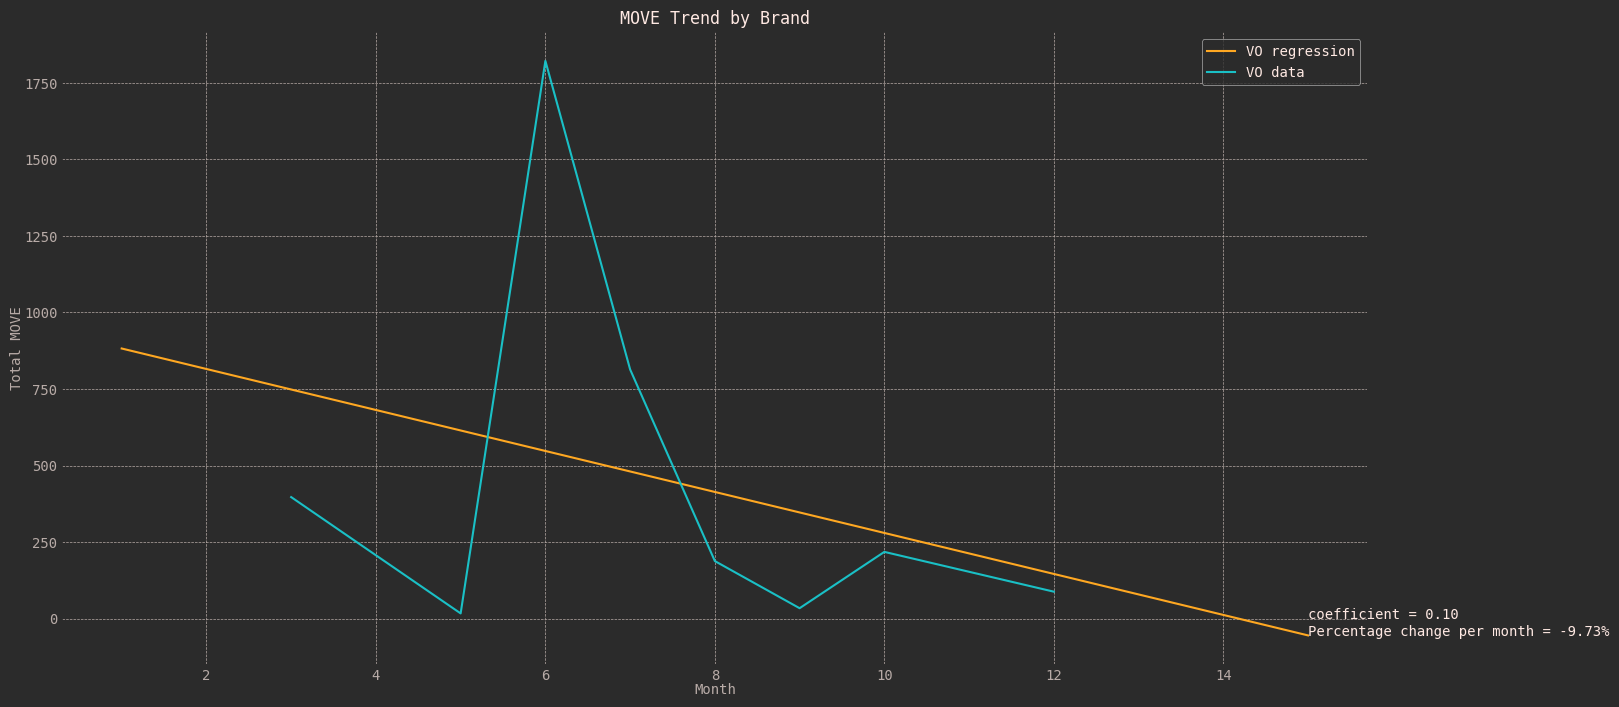

In [205]:
# Brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][1]

# Category I want to predict
category = "MOVE"

# Create new df because needing more month data
input_file = "data_clean/month_shampoo_sale_data.csv"
df_sale = pd.read_csv(input_file)

# Number of months I want to predict into the future
future_months = 3

brand_trend_graph(df_sale, selected_brands, min_month=1, max_month=12, column=category, future_months=future_months)

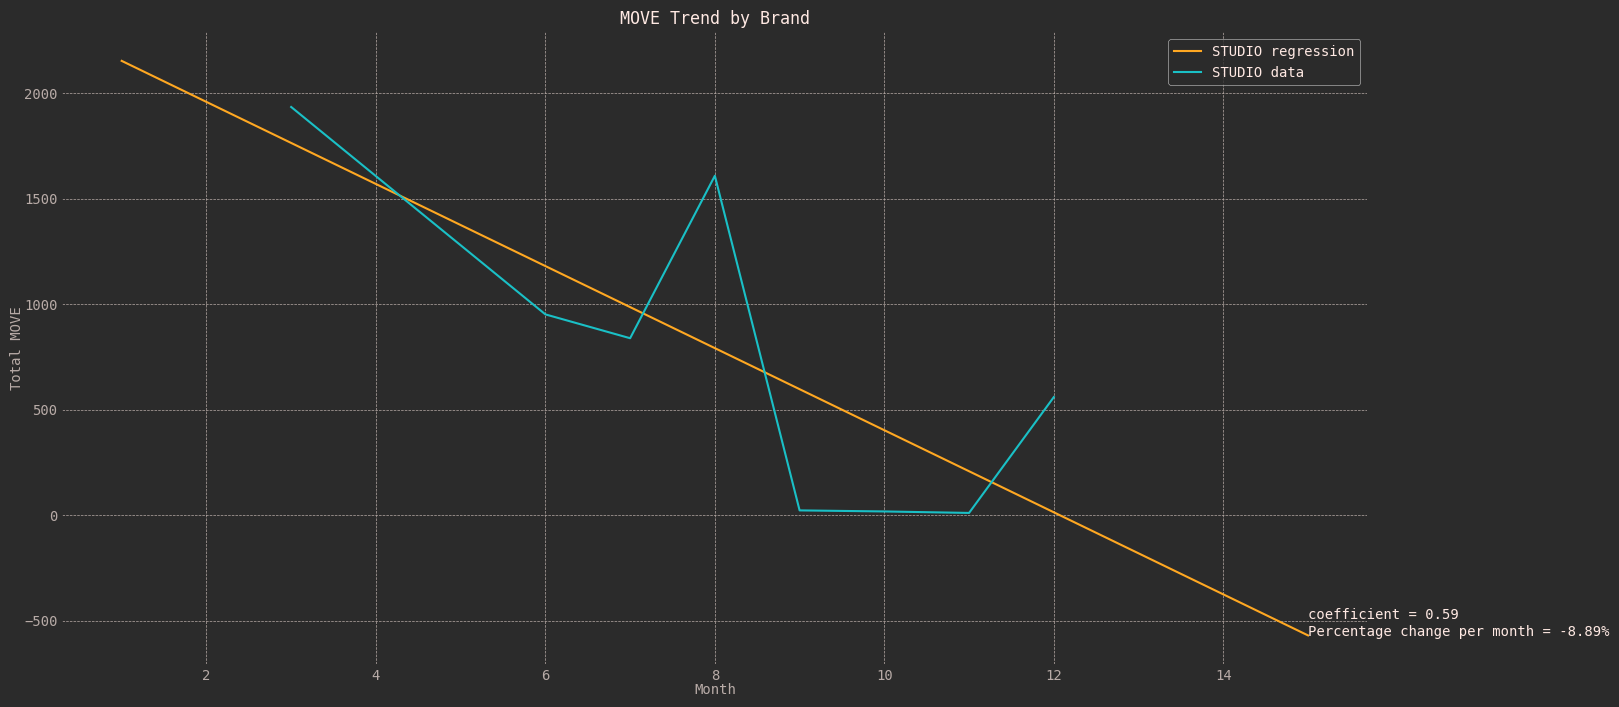

In [206]:
# Brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][2]

# Category I want to predict
category = "MOVE"

# Create new df because needing more month data
input_file = "data_clean/month_shampoo_sale_data.csv"
df_sale = pd.read_csv(input_file)

# Number of months I want to predict into the future
future_months = 3

brand_trend_graph(df_sale, selected_brands, min_month=1, max_month=12, column=category, future_months=future_months)

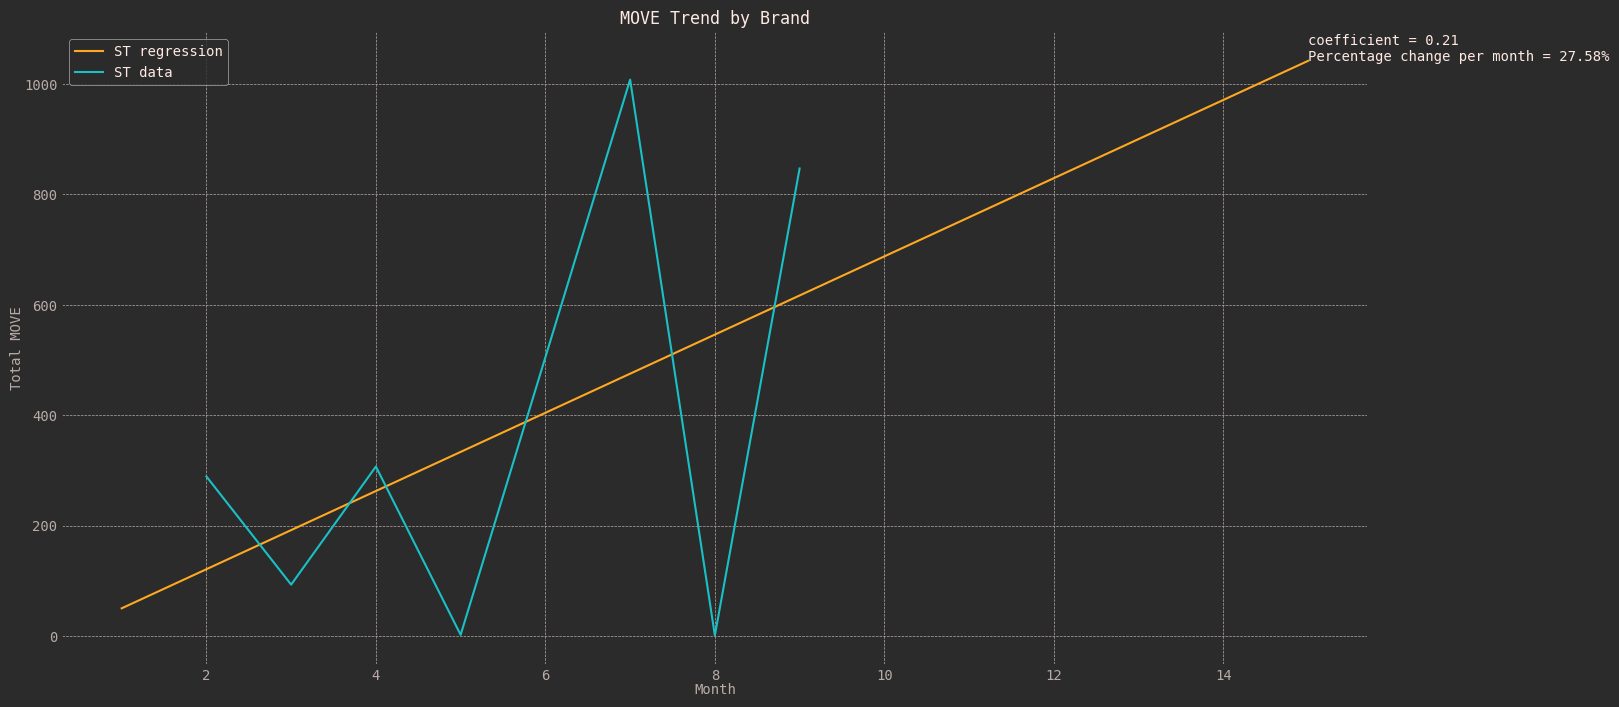

In [207]:
# Brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][3]

# Category I want to predict
category = "MOVE"

# Create new df because needing more month data
input_file = "data_clean/month_shampoo_sale_data.csv"
df_sale = pd.read_csv(input_file)

# Number of months I want to predict into the future
future_months = 3

brand_trend_graph(df_sale, selected_brands, min_month=1, max_month=12, column=category, future_months=future_months)

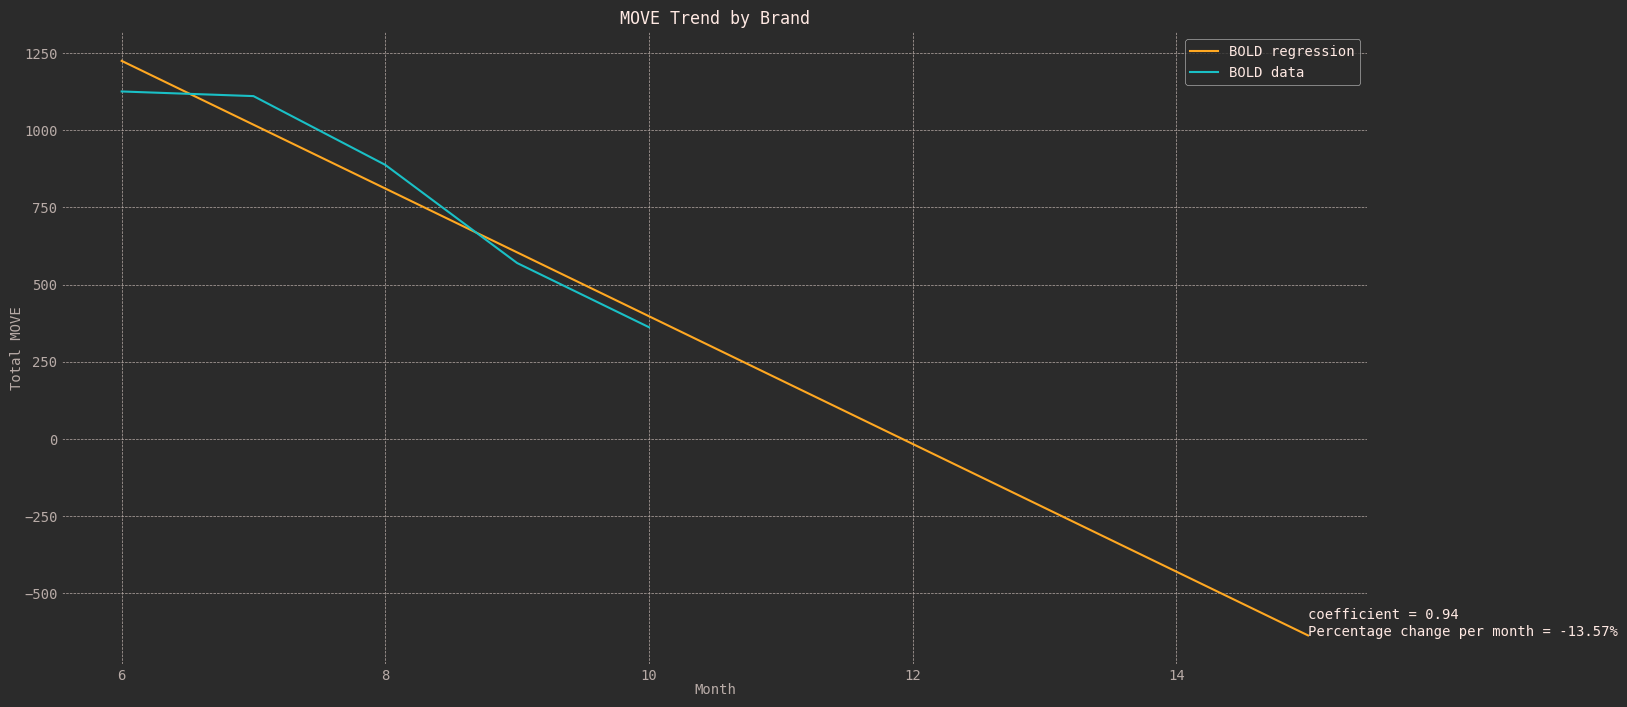

In [209]:
# Brands
selected_brands = ["VO5","VO","STUDIO", "ST", "BOLD"][4]

# Category I want to predict
category = "MOVE"

# Create new df because needing more month data
input_file = "data_clean/month_shampoo_sale_data.csv"
df_sale = pd.read_csv(input_file)

# Number of months I want to predict into the future
future_months = 3

brand_trend_graph(df_sale, selected_brands, min_month=6, max_month=12, column=category, future_months=future_months)